In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, sys.path[0]+'/../..')
import argparse
import os
import numpy as np
import random
import math
import torch
#from utils import seed_all_randomness, load_corpus, loading_all_models, str2bool
#from utils import load_idx2word_freq, loading_all_models, load_testing_article_summ, str2bool
from utils import load_idx2word_freq, loading_all_models, str2bool
import utils
import utils_testing
import spacy
from spacy.lang.en import English
from sklearn.manifold import TSNE, MDS
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
from collections import Counter

#hyperparameter setup
parser = argparse.ArgumentParser(description='PyTorch Neural Set Decoder for Sentnece Embedding')

###path

parser.add_argument('--word_dict', type=str, default='../data/processed/wiki2016_min100/dictionary_index',
                    help='path to a dictionary file')
parser.add_argument('--checkpoint', type=str, default='./models/',
                    help='model checkpoint to use')
parser.add_argument('--emb_file', type=str, default='target_emb.pt',
                    help='path to a word embedding file')
parser.add_argument('--stop_word_file', type=str, default='../../../resources/stop_word_list',
                    help='path to the file of stop words')
#parser.add_argument('--tensor_folder', type=str, default='tensors',
#                    help='location of the data corpus')
#parser.add_argument('--data', type=str, default='./data/processed/wackypedia/',
#                    help='location of the data corpus')
#parser.add_argument('--outf', type=str, default='gen_log/generated.txt',
#                    help='output file for generated text')

###system
#parser.add_argument('--cuda', type=str2bool, nargs='?', default=True,
parser.add_argument('--cuda', type=str2bool, nargs='?', default=False,
                    help='use CUDA')
parser.add_argument('--single_gpu', default=False, action='store_true',
                    help='use single GPU')
parser.add_argument('--batch_size', type=int, default=50, metavar='N',
                   help='batch size')
#parser.add_argument('--seed', type=int, default=1111,
#                    help='random seed')
#parser.add_argument('--max_batch_num', type=int, default=100,
#                    help='number of batches for evaluation')

utils_testing.add_model_arguments(parser)

args = parser.parse_args("""--checkpoint ../../../models/wiki2016-20200111-150559 
                            --word_dict ../../../data/processed/wiki2016_min100/dictionary_index
                            --n_basis 10""".split())

#args = parser.parse_args("""--checkpoint ../../../models/wiki2016-20200118-213342
#                            --word_dict ../../../data/processed/wiki2016_min100/dictionary_index
#                            --n_basis 5""".split())

#args = parser.parse_args("""--checkpoint ../../../models/wiki2016-20200113-102754
#                            --word_dict ../../../data/processed/wiki2016_min100/dictionary_index
#                            --n_basis 3""".split())

#args = parser.parse_args("""--checkpoint ../../../models/wiki2016-20200113-134659
#                            --word_dict ../../../data/processed/wiki2016_min100/dictionary_index
#                            --n_basis 30""".split())


device = torch.device("cuda" if args.cuda else "cpu")

In [2]:
#load all models

if args.emb_file == "target_emb.pt":
    args.emb_file =  os.path.join(args.checkpoint,"target_emb.pt")

with open(args.word_dict) as f_in:
    idx2word_freq = load_idx2word_freq(f_in)

word_d2_idx_freq = {}
#word_d2_idx = {}
for i in range(len(idx2word_freq)):
    w, freq = idx2word_freq[i]
    #word_d2_idx[w] = i
    word_d2_idx_freq[w] = [i, freq]
    
max_sent_len = 150
parallel_encoder, parallel_decoder, encoder, decoder, word_norm_emb = loading_all_models(args, idx2word_freq, device, max_sent_len)
encoder.eval()
decoder.eval()
#print(word_norm_emb[[0,1,2,10],:])
#print(word_norm_emb[torch.tensor([0],dtype=torch.long,device=device),:])

pipeline = ["sentencizer"]

spacy_tokenizer = English()
for name in pipeline:
    component = spacy_tokenizer.create_pipe(name)
    spacy_tokenizer.add_pipe(component)


Using Tranformer decoder


In [3]:
def pred_basis(feature, parallel_encoder, parallel_decoder, word_norm_emb):
    top_k = 1
    coeff_pred, basis_norm_pred, output_emb_last, output_emb = utils_testing.predict_batch_simple(feature, parallel_encoder, parallel_decoder)
    basis_norm_pred = basis_norm_pred.permute(0,2,1)
    #sim_pairwise = torch.matmul(word_norm_emb.unsqueeze(dim = 0), basis_norm_pred)
    sim_pairwise = torch.matmul(word_norm_emb, basis_norm_pred)
    top_value, top_index = torch.topk(sim_pairwise, top_k, dim = 1, sorted=True)
    #word_emb_input = word_norm_emb[feature,:]    
    #word_basis_sim = torch.bmm( word_emb_input, basis_norm_pred )
    #word_basis_sim_pos_sum = word_basis_sim.clamp(min = 0).sum(dim=2)
    word_basis_sim_pos_sum = None
    return basis_norm_pred, top_value, top_index, word_basis_sim_pos_sum


def merge_sents(document_list, num_sent_pred, max_sent_len):
    article = []
    reaching_max_len_num = 0
    #i = 0
    current_buffer = []
    current_sent_num = 0
    for i in range(len(document_list)):
    #while( i < len(document_list) ):
        w_list = document_list[i]
        current_buffer += w_list
        current_sent_num += 1
        if i == len(document_list) - 1:
            article.append(current_buffer)
        else:
            w_list_next = document_list[i+1]
            if current_sent_num >= num_sent_pred or len(current_buffer) + len(w_list_next) >= max_sent_len:
                if len(current_buffer) + len(w_list_next) >= max_sent_len:
                    reaching_max_len_num += 1
                article.append(current_buffer) #assume load_testing_article_summ will exclude the case where single sentence is longer than max_sent_len
                current_buffer = []
                current_sent_num = 0
                
     #   i += 1
                        
    return article, reaching_max_len_num

class F2SetDataset(torch.utils.data.Dataset):
#will need to handle the partial data loading if the dataset size is larger than cpu memory
#We could also use this class to put all sentences with the same length together
    def __init__(self, feature, target, device):
        self.feature = feature
        self.target = target
        self.output_device = device

    def __len__(self):
        return self.feature.size(0)

    def __getitem__(self, idx):
        feature = torch.tensor(self.feature[idx, :], dtype = torch.long, device = self.output_device)
        target = torch.tensor(self.target[idx, :, :], device = self.output_device)
        #debug target[-1] = idx
        return [feature, target]

def load_testing_article_local(word_d2_idx_freq, article, word_norm_emb_arr_tensor, max_sent_len, eval_bsz, device):
    feature_tensor = utils.convert_sent_to_tensor(article, max_sent_len, word_d2_idx_freq)
    dataset = F2SetDataset(feature_tensor, word_norm_emb_arr_tensor, device)
    use_cuda = False
    if device.type == 'cude':
        use_cuda = True
    dataloader_test = torch.utils.data.DataLoader(dataset, batch_size = eval_bsz, shuffle = False, pin_memory=use_cuda, drop_last=False)
    return dataloader_test

#def compute_bases(num_sent_pred, word_d2_idx_freq, document_list, parallel_encoder, parallel_decoder, word_norm_emb, max_sent_len, eval_bsz, device):
def compute_bases(num_sent_pred, word_d2_idx_freq, document_list, parallel_encoder, parallel_decoder, word_norm_emb_arr_tensor, max_sent_len, eval_bsz, device):
    with torch.no_grad():
        article, reaching_max_len_num = merge_sents(document_list, num_sent_pred, max_sent_len)
        article = [' '.join(w_list) for w_list in article]
        dataloader_test = load_testing_article_local(word_d2_idx_freq, article, word_norm_emb_arr_tensor, max_sent_len, eval_bsz, device)
        #dataloader_test = load_testing_article_summ(word_d2_idx_freq, article, word_norm_emb, max_sent_len, eval_bsz, device)
        basis_pool = []
        top_k_pool = []
        top_k_value_pool = []
        for feature, target in dataloader_test:
            #basis_norm_pred, top_value, top_index, word_basis_sim_pos_sum = pred_basis(feature, parallel_encoder, parallel_decoder, word_norm_emb)
            basis_norm_pred, top_value, top_index, word_basis_sim_pos_sum = pred_basis(feature, parallel_encoder, parallel_decoder, target)
            basis_pool.append( basis_norm_pred )
            #top_k_pool.append( [top_value, top_index] )
            top_k_pool.append( top_index )
            top_k_value_pool.append( top_value )
            #print(top_index[0,:,:])
            #print(top_index.size())
    return basis_pool, top_k_pool, top_k_value_pool

#def dimension_reduction_model(document_word_idx_uniq, word_norm_emb):
#    all_word_embs = word_norm_emb[document_word_idx_uniq,:]
#    mds_model = MDS()
#    all_word_embs_low = mds_model.fit_transform(all_word_embs)
#    return mds_model, all_word_embs_low


#def compress_basis(basis_pool, top_k_pool, idx2word_freq, stop_ind_set, doc_word_embs_low):
#def compress_basis(basis_pool, top_k_pool, idx2word_freq, doc_word_embs_low):
def compress_basis(basis_pool, top_k_pool, top_k_value_pool, idx2word_freq_arr, idx_local_l2_idx_doc_arr, doc_word_embs_low):
    def compute_edge_weight(sent_idx, basis_val, basis_val_nei, sent_idx_d2_idx_nei):
        edge_w = 0
        for i in range(len(sent_idx)):
            sent_idx_i = sent_idx[i]
            #print(sent_idx_i)
            #print(sent_idx_d2_idx_nei)
            if sent_idx_i not in sent_idx_d2_idx_nei:
                continue
            edge_w += np.sqrt(basis_val[i] * basis_val_nei[sent_idx_d2_idx_nei[sent_idx_i]])
        return edge_w
    with torch.no_grad():
        basis_cat = torch.cat(basis_pool,dim = 0)
        top_k_cat = torch.cat(top_k_pool,dim = 0)
        top_k_value_cat = torch.cat(top_k_value_pool,dim = 0)
        
        #print(basis_cat.size())
        basis_cat_mean = basis_cat.mean(dim=2)
        basis_cat_mean_norm = basis_cat_mean / (0.000000000001 + basis_cat_mean.norm(dim = -1, keepdim=True))
        emb_size = basis_cat.size(1)
        all_basis_embs = basis_cat.permute(0,2,1).reshape(-1,emb_size).cpu().numpy()
        #center_embs = basis_cat_mean_norm.cpu().numpy()
        all_idx = top_k_cat.permute(0,2,1).reshape(-1).cpu().numpy()
        all_value = top_k_value_cat.permute(0,2,1).reshape(-1).cpu().numpy()
        
        node_d2_info = {}
        #num_basis = basis_cat.size(1)
        for i in range(all_idx.shape[0]):
            #if all_value[i] <= 0.5:
            if all_value[i] <= 0:
                continue
            word_idx = all_idx[i]
            #if word_idx in stop_ind_set:
            #    continue
            sent_idx = int(i / args.n_basis)
            #print(sent_idx)
            #print(word_idx)
            #print(len(idx2word_freq_arr[sent_idx]))
            word = idx2word_freq_arr[sent_idx][word_idx][0]
            word_idx_doc = idx_local_l2_idx_doc_arr[sent_idx][word_idx]
            #word = idx2word_freq[word_idx][0].lower()
            if word not in node_d2_info:
                node_d2_info[word] = [word_idx_doc, [], [], []]
            node_d2_info[word][1].append(i)
            node_d2_info[word][2].append(sent_idx)
            node_d2_info[word][3].append(all_value[i])
            #node_d2_info[word][2].append(int(i / args.n_basis))
        for word in node_d2_info:
            word_idx, basis_idx, sent_idx, basis_val = node_d2_info[word]
            basis_embs_mean = all_basis_embs[basis_idx,:].mean(axis=0,keepdims=True)
            #node_d2_info[word][2] = set(sent_idx)
            node_d2_info[word].append(sum(basis_val))
            node_d2_info[word].append({sent_idx_i:i for i, sent_idx_i in enumerate(sent_idx)})
            #node_d2_info[word].append(len(basis_idx))
            #node_d2_info[word].append(len(node_d2_info[word][2]))
            node_d2_info[word].append(basis_embs_mean)

        node_info_arr = node_d2_info.items()
        G = nx.Graph()
        for i, (word, node_info) in enumerate(node_info_arr):
            i_nei_d2_link = {}
            sent_idx = node_info[2]
            basis_val = node_info[3]
            for i_nei, (word_nei, node_info_nei) in enumerate(node_info_arr):
                if i == i_nei:
                    continue
                #sent_idx_nei = node_d2_info[w_idx_nei][2]
                #sent_idx_nei = node_info_nei[2]
                basis_val_nei = node_info_nei[3]
                sent_idx_d2_idx_nei = node_info_nei[5]
                #edge_w = len(sent_idx.intersection(sent_idx_nei))
                edge_w = compute_edge_weight(sent_idx, basis_val, basis_val_nei, sent_idx_d2_idx_nei)
                i_nei_d2_link[i_nei] = edge_w
                G.add_edge(i, i_nei, weight = edge_w + 0.0001 * (node_info_nei[4]+node_info[4]) )
            node_info.append(i_nei_d2_link)
        labels, info_arr = zip(*node_info_arr)
        w_idx_arr, basis_idx_list_arr, sent_idx_list_arr, basis_val_list_arr, node_size_arr, sent_idx_d2_idx_arr, basis_embs_mean_arr, i_nei_d2_link_arr = zip(*info_arr)
        all_basis_embs = np.concatenate(basis_embs_mean_arr)
        #labels = []
        #for i in range(all_idx.shape[0]):
        #    labels.append(idx2word_freq[all_idx[i]][0])
        
    #tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=1000, random_state=23)
    #all_basis_embs_low = tsne_model.fit_transform(all_basis_embs)
    #all_basis_embs_low = mds_model.fit_transform(all_basis_embs)
    #all_basis_embs_low = mds_model.transform(all_basis_embs)
    all_basis_embs_low = doc_word_embs_low[w_idx_arr,:]
    #center_embs_low = mds_model.fit_transform(center_embs)
    T = nx.maximum_spanning_tree(G)

    #print(all_basis_embs_low)
    #print(labels)
    #return all_basis_embs_low, center_embs_low, labels
    return all_basis_embs_low, node_size_arr, i_nei_d2_link_arr, labels, T

            
def spacy_parse(text, spacy_tokenizer, word_d2_idx_freq):
    doc = spacy_tokenizer(text, disable=['parser', 'tagger', 'ner'])
    doc.is_parsed = True
    output_doc = []
    output_doc_idx = []
    output_doc_proc = []
    for sent in doc.sents:
        w_list = []
        w_proc_list = []
        w_idx_list = []
        for w in sent:
            if '\n' not in w.text and ' ' not in w.text:
                w_list.append(w.text)
                if w.text in word_d2_idx_freq:
                    w_idx_list.append(word_d2_idx_freq[w.text][0])
                    w_proc_list.append(w.text)
                else:
                    w_idx_list.append(word_d2_idx_freq['<unk>'][0])
                    w_proc_list.append('<unk>')
            #print(w.text)
        if len(w_list) > 0:
            output_doc.append(w_list)
            output_doc_idx.append(w_idx_list+[word_d2_idx_freq['<eos>'][0]])
            output_doc_proc.append(w_proc_list+['<eos>'])
            
    return output_doc_idx, output_doc, output_doc_proc

#def visualize_embs(center_embs_low, all_basis_embs_low, labels):
#def visualize_embs(all_basis_embs_low, node_size_arr, i_nei_d2_link_arr, labels, T):
def visualize_embs(all_basis_embs_low, node_size_arr, labels, T, node_c = 'red', edge_c = 'black', figure_id = None):
    plt.figure(figure_id, figsize=(16, 16)) 
    #x_c, y_c = zip(*center_embs_low) 
    #for i in range(len(x_c)):
    #    plt.scatter(x_c[i], y_c[i], marker="o",color='green', s=200)

    x, y = zip(*all_basis_embs_low)
    for i, i_nei, edge_data in T.edges(data=True):
        #plt.plot([x[i],x[i_nei]], [y[i],y[i_nei]], zorder=1,color='black', linewidth=i_nei_d2_link_arr[i][i_nei])
        #plt.plot([x[i],x[i_nei]], [y[i],y[i_nei]], zorder=1,color='black', linewidth=int(edge_data['weight']))
        plt.plot([x[i],x[i_nei]], [y[i],y[i_nei]], zorder=1,color=edge_c, linewidth=edge_data['weight'], alpha=0.3)
    #size_max = max(node_size_arr)
    #for i in range(len(x)):
    #    #idx_c = int(i / args.n_basis)
    #    #if node_size_arr[i] == size_max:
    #    if node_size_arr[i] > 1:
    #    #if True:
    #        for i_nei in i_nei_d2_link_arr[i]:
    #            plt.plot([x[i],x[i_nei]], [y[i],y[i_nei]], zorder=1,color='black', linewidth=i_nei_d2_link_arr[i][i_nei])
    #    #plt.annotate(labels[i],xy=(x[i], y[i]),xytext=(3*node_size_arr[i], 3*node_size_arr[i]),textcoords='offset points',ha='right',va='bottom',color='green')
    #idx_arr_sorted = np.flip(np.argsort(node_size_arr))
    idx_arr_sorted = np.argsort(node_size_arr)
    for i in idx_arr_sorted:
    #for i in range(len(x)):
        bbox_props = dict(fc="cyan", ec="b")
        plt.annotate(labels[i],xy=(x[i], y[i]),xytext=(12+node_size_arr[i], 12+node_size_arr[i]), zorder=3,textcoords='offset points',ha='center',va='center',bbox=bbox_props)
        plt.scatter(x[i], y[i], marker="v",color=node_c, s=200*node_size_arr[i], zorder=2, alpha=0.3)
        
        
def constraint_word_space(document_word_idx_uniq, word_norm_emb, idx2word_freq, device):
    #print(max(document_word_idx_uniq))
    #print(word_norm_emb.size())
    word_norm_emb_doc = word_norm_emb[torch.tensor(document_word_idx_uniq,dtype=torch.long,device=device),:]
    #word_norm_emb_doc = word_norm_emb[torch.tensor([0,1,2,3,4],dtype=torch.long,device=device),:]
    idx2word_freq_doc = [idx2word_freq[x] for x in document_word_idx_uniq]
    return word_norm_emb_doc, idx2word_freq_doc

def constraint_word_space_sent(document_word_idx, stop_ind_set_doc, word_norm_emb, idx2word_freq, w_idx_d2_doc_idx, device):
    word_norm_emb_arr = []
    idx2word_freq_arr = []
    max_sent_len = 0
    idx_local_l2_idx_doc_arr = []
    for w_list in document_word_idx:
        w_list_no_stop = list(set([w for w in w_list if w not in stop_ind_set_doc]))
        if len(w_list_no_stop) > max_sent_len:
            max_sent_len = len(w_list_no_stop)
        word_norm_emb_arr.append(word_norm_emb[w_list_no_stop,:])
        idx2word_freq_arr.append([idx2word_freq[x] for x in w_list_no_stop])
        idx_local_l2_idx_doc_arr.append([w_idx_d2_doc_idx[x] for x in w_list_no_stop])
            
    
    emb_size = word_norm_emb.size(1)
    word_norm_emb_arr_tensor = torch.zeros( (len(word_norm_emb_arr), max_sent_len, emb_size), device=device )
    for i in range(len(word_norm_emb_arr)):
        word_norm_emb_sent = word_norm_emb_arr[i]
        sent_len = word_norm_emb_sent.size(0)
        word_norm_emb_arr_tensor[i,:sent_len,:] = word_norm_emb_sent
    
    return word_norm_emb_arr_tensor, idx2word_freq_arr, idx_local_l2_idx_doc_arr

def convert_stop_to_ind_lower(f_in, idx2word_freq):
    stop_word_org_set = set()
    for line in f_in:
        w = line.rstrip()
        stop_word_org_set.add(w)
    stop_word_set = set()
    for idx, (w, freq) in enumerate(idx2word_freq):
        if w.lower() in stop_word_org_set:
            stop_word_set.add(idx)
    return stop_word_set

def merge_graph(all_basis_embs_low_hier, node_size_arr_hier, i_nei_d2_link_arr_hier, labels_hier):
    #w_d2_idx_arr = []
    #w_d2_link_arr_hier = [] 
    #for i in range(len(labels_hier)):
        #w_d2_idx = {w:j for j,w in enumerate(labels_hier)}
        #w_d2_idx_arr.append(w_d2_idx)
    w_d2_embs_size_edge = {}
    hier_size = len(labels_hier)
    for i in range(hier_size):
        #i_nei_d2_link_arr = i_nei_d2_link_arr_hier[i]
        #w_d2_link_arr = []
        #for j in range(len(i_nei_d2_link_arr)):
        #    i_nei_d2_link = i_nei_d2_link_arr[j]
        #    w_d2_link = {labels_hier[i][j_nei]: link_w for j_nei, link_w in i_nei_d2_link.items()}
        #    w_d2_link_arr.append(w_d2_link)
        for j, w in enumerate(labels_hier[i]):
            if w not in w_d2_embs_size_edge:
                w_d2_embs_size_edge[w] = [all_basis_embs_low_hier[i][j], 0, {}]
            w_d2_embs_size_edge[w][1] += node_size_arr_hier[i][j] / hier_size
            i_nei_d2_link = i_nei_d2_link_arr_hier[i][j]
            #w_nei_d2_link = {labels_hier[i][j_nei]: link_w for j_nei, link_w in i_nei_d2_link.items()}
            for j_nei in i_nei_d2_link:
                link_w = i_nei_d2_link[j_nei]
                w_nei = labels_hier[i][j_nei]
                link_w_current = w_d2_embs_size_edge[w][2].get(w_nei, 0)
                w_d2_embs_size_edge[w][2][w_nei] = link_w_current + link_w / hier_size
                
    labels, embs_size_edge_arr = zip(*w_d2_embs_size_edge.items())
    all_basis_embs_low, node_size_arr, edge_dict_arr = zip(*embs_size_edge_arr)
    w_d2_new_idx = {w: idx for idx, w in enumerate(labels)}
    G = nx.Graph()
    for i, w in enumerate(labels):
        for w_nei in edge_dict_arr[i]:
            i_nei = w_d2_new_idx[w_nei]
            G.add_edge(i, i_nei, weight=edge_dict_arr[i][w_nei])
    T_doc = nx.maximum_spanning_tree(G)
    
    return all_basis_embs_low, node_size_arr, labels, T_doc

def compute_word_graph(document_word_idx_uniq, document_word_idx_flat, document_word_idx, w_idx_d2_local_idx, idx2word_freq_doc, stop_ind_set_doc):
    doc_counter = Counter(document_word_idx_flat)

    labels_doc, freq_doc = zip(*idx2word_freq_doc)
    node_size_arr_doc = []
    for w_idx in document_word_idx_uniq:
        node_size_arr_doc.append(doc_counter[w_idx])


    document_word_idx_no_stop = [[w_idx for w_idx in w_list if w_idx not in stop_ind_set_doc] for w_list in document_word_idx]
    w_idx_d2_w_idx_nei_d2_count = {}
    for w_list in document_word_idx_no_stop: 
        for w_idx in w_list:
            w_idx_nei_d2_count = w_idx_d2_w_idx_nei_d2_count.get(w_idx,{})
            for w_idx_nei in w_list:
                count = w_idx_nei_d2_count.get(w_idx_nei,0)
                w_idx_nei_d2_count[w_idx_nei] = count + 1
            w_idx_d2_w_idx_nei_d2_count[w_idx] = w_idx_nei_d2_count
    #for w_list in document_list:

    G = nx.Graph()

    for w_idx in w_idx_d2_w_idx_nei_d2_count:
        w_idx_nei_d2_count = w_idx_d2_w_idx_nei_d2_count[w_idx]
        for w_idx_nei in w_idx_nei_d2_count:
            count = w_idx_nei_d2_count[w_idx_nei]
            local_w_idx = w_idx_d2_local_idx[w_idx]
            local_w_idx_nei = w_idx_d2_local_idx[w_idx_nei]
            G.add_edge(local_w_idx, local_w_idx_nei, weight=count + 0.0001 * (node_size_arr_doc[local_w_idx] + node_size_arr_doc[local_w_idx_nei]))
    T_doc = nx.maximum_spanning_tree(G)
    return node_size_arr_doc, labels_doc, T_doc

def doc_preprocessing(document_str, stop_ind_set_doc):
    document_word_idx, document_list, document_proc_list = spacy_parse(document_str, spacy_tokenizer, word_d2_idx_freq)

    document_word_idx_flat = [w_idx for w_list in document_word_idx for w_idx in w_list if w_idx not in stop_ind_set_doc]
    document_word_idx_uniq = list(set(document_word_idx_flat))
    print(str(len(document_word_idx_uniq)) + ' unique words')

    word_norm_emb_doc, idx2word_freq_doc = constraint_word_space(document_word_idx_uniq, word_norm_emb, idx2word_freq, device)

    w_idx_d2_local_idx = {}
    for i in range(len(document_word_idx_uniq)):
        w_idx_d2_local_idx[document_word_idx_uniq[i]] = i
        
    node_size_arr_doc, labels_doc, T_doc = compute_word_graph(document_word_idx_uniq, document_word_idx_flat, document_word_idx, w_idx_d2_local_idx, idx2word_freq_doc, stop_ind_set_doc)
        
    word_norm_emb_arr_tensor, idx2word_freq_arr, idx_local_l2_idx_doc_arr = constraint_word_space_sent(document_word_idx, stop_ind_set_doc, word_norm_emb, idx2word_freq, w_idx_d2_local_idx, device)
    
    return word_norm_emb_doc, node_size_arr_doc, labels_doc, T_doc, document_list, word_norm_emb_arr_tensor, idx2word_freq_arr, idx_local_l2_idx_doc_arr
    
def join_mds_emb(word_norm_emb_doc_1, word_norm_emb_doc_2, labels_doc_1, labels_doc_2, device):
    doc_size_1, emb_size = word_norm_emb_doc_1.size()
    doc_size_2 = word_norm_emb_doc_2.size(0)
    #emb_size = word_norm_emb_doc_1.size(1)
    labels_doc_12 = list(set(labels_doc_1+labels_doc_2)) 
    w_d2_merge_idx = {w:i for i,w in enumerate(labels_doc_12)}
    num_word = len(labels_doc_12)
    #word_norm_emb_doc_12 = torch.empty( (num_word, emb_size) , device=device)
    word_norm_emb_doc_12 = np.empty( (num_word, emb_size) )
    w_d2_emb = {w: word_norm_emb_doc_1[i,:] for i, w in enumerate(labels_doc_1)}
    w_d2_emb.update({w: word_norm_emb_doc_2[i,:] for i, w in enumerate(labels_doc_2)})
    for i, w in enumerate(labels_doc_12):
        word_norm_emb_doc_12[i,:] = w_d2_emb[w]

    mds_model = MDS()
    #word_norm_emb_doc_12 = torch.cat( (word_norm_emb_doc_1, word_norm_emb_doc_2), dim=0 )
    doc_word_embs_low_12 = mds_model.fit_transform(word_norm_emb_doc_12)
        
    #idx_1_d2_merge_idx = {}
    #doc_word_embs_low_1 = torch.empty( (doc_size_1, emb_size) , device=device)
    doc_word_embs_low_1 = np.empty( (doc_size_1, 2))
    for i, w in enumerate(labels_doc_1):
        doc_word_embs_low_1[i,:] = doc_word_embs_low_12[w_d2_merge_idx[w],:]
        #idx_1_d2_merge_idx[i] = w_d2_merge_idx[w]
    
    #doc_word_embs_low_2 = torch.empty( (doc_size_2, emb_size) , device=device)
    doc_word_embs_low_2 = np.empty( (doc_size_2, 2))
    for i, w in enumerate(labels_doc_2):
        doc_word_embs_low_2[i,:] = doc_word_embs_low_12[w_d2_merge_idx[w],:]    
    
    #doc_word_embs_low_1 = doc_word_embs_low_12[:doc_size_1, :]
    #doc_word_embs_low_2 = doc_word_embs_low_12[doc_size_1:, :]
    return doc_word_embs_low_1, doc_word_embs_low_2

def compare_summarization(node_c, edge_c, doc_word_embs_low, node_size_arr_doc, labels_doc, T_doc, document_list, word_norm_emb_arr_tensor, idx2word_freq_arr, idx_local_l2_idx_doc_arr):
    batch_size = args.batch_size
    batch_size = 10

    all_basis_embs_low_hier = []
    node_size_arr_hier = [] 
    i_nei_d2_link_arr_hier = []
    labels_hier = []

    num_sent_pred_max = 5

    for num_sent_pred in range(1,num_sent_pred_max+1):
        basis_pool = None
        top_k_pool = None
        del basis_pool, top_k_pool
        basis_pool, top_k_pool, top_k_value_pool = compute_bases(num_sent_pred, word_d2_idx_freq, document_list, parallel_encoder, parallel_decoder, word_norm_emb_arr_tensor, max_sent_len, batch_size , device)
        all_basis_embs_low, node_size_arr, i_nei_d2_link_arr, labels, T = compress_basis(basis_pool, top_k_pool, top_k_value_pool, idx2word_freq_arr, idx_local_l2_idx_doc_arr, doc_word_embs_low)
        all_basis_embs_low_hier.append(all_basis_embs_low)
        node_size_arr_hier.append(node_size_arr)
        i_nei_d2_link_arr_hier.append(i_nei_d2_link_arr)
        labels_hier.append(labels)
        print("Number of nodes: ", len(node_size_arr))
        #visualize_embs(all_basis_embs_low, node_size_arr, labels, T)

    for i_base in range(num_sent_pred_max-1,-1,-1):
        all_basis_embs_low, node_size_arr, labels, T = merge_graph(all_basis_embs_low_hier[i_base:], node_size_arr_hier[i_base:], i_nei_d2_link_arr_hier[i_base:], labels_hier[i_base:])
        visualize_embs(all_basis_embs_low, node_size_arr, labels, T, node_c = node_c, edge_c = edge_c, figure_id = i_base)
    visualize_embs(doc_word_embs_low, node_size_arr_doc, labels_doc, T_doc, node_c = node_c, edge_c = edge_c, figure_id = num_sent_pred_max)


In [4]:

document_str = """Facebook is not waiting for its initial public offering to make its first big purchase.

In its largest acquisition to date, the social network has purchased Instagram, the popular photo-sharing application, for about $1 billion in cash and stock, the company said Monday.

It’s a notable move for Facebook, which has exclusively focused on bite-size acquisitions, worth less than $100 million.

With Instagram, Facebook will get a formidable mobile player – an area that is seen as a weakness for the sprawling social network. Founded two years ago, the service — which lets users share photos and apply stylized filters – has become one of the most downloaded applications on the iPhone, with some 30 million users. Instagram released a version of its application for Google’s Android operating system last week.

On Monday, both companies expressed their commitment to run Instagram as an independent service.

In a post on his profile page, Facebook’s chief Mark Zuckerberg said Instagram would continue to work with rival social networks. That will allow users to post on other services, follow users outside of Facebook, and to opt out of sharing on Facebook.

“For years, we’ve focused on building the best experience for sharing photos with your friends and family,” Mr. Zuckerberg wrote. “Now, we’ll be able to work even more closely with the Instagram team to also offer the best experiences for sharing beautiful mobile photos with people based on your interests.”

In a separate blog post on Instagram’s Web site, the company’s chief executive, Kevin Systrom, also reiterated plans to preserve the service’s functionality and said he looked forward to leveraging the new parent company’s resources and talent.

The announcement comes as Facebook prepares for its highly anticipated initial public offering, widely expected to take place next month.

Though Facebook is known for smaller acquisitions, Instagram’s surging momentum likely compelled the social network to swiftly put together a billion-dollar offer. Last week, Instagram, which has just a handful of employees, closed a financing round worth more than $50 million with several prominent investors, including Sequoia Capital, an early backer of Google, Thrive Capital, the firm run by Joshua Kushner, and Greylock Capital, an early investor of LinkedIn. AllThingsD first reported last week that Sequoia was in the process of leading a $50 million round in Instagram.

That latest funding round valued Instagram at about $500 million, according to one person with knowledge of the matter, who requested anonymity because discussions were private. Facebook’s purchase, one week later, means that investment has now doubled in value.

The deal is expected to close later this quarter, according to Facebook’s statement.
"""

In [21]:
document_str_2 = """Moments ago the deal was confirmed. In their largest acquisition to date, Google has acquired YouTube for $1.65 billion in an all stock transaction. Both companies have approved the deal, which should officially close in the fourth quarter. YouTube’s  65 employees will remain with the company at YouTube’s San Bruno headquarters.

Details are also emerging that Yahoo was in the bidding war until very close to the end.

Google  is hosting a conference call and webcast to discuss the deal. My notes are below, and a recording of the call is here. You can also hear a replay of the call via telephone until midnight Monday, October 16 at 888-203-1112 domestically and 719-457-0820 internationally. Confirmation code for the replay is 2260624.

This went from rumor to reality incredibly fast.

My Notes from the call:

Eric Schmidt, Google’s CEO, Chad Hurley, YouTube’s CEO, David Drummond, Google’s General Counsel and others are on the call.

Eric is starting the call and immediately started talking about the content deals announced today. He says Chad Hurley and Steven Chen, YouTube’s founders, remind him of Larry and Sergey.

Chad is now talking about the reasons he agreed to be acquired by Google. He says Google’s ad platform will integrate perfectly into YouTube. Says the cultures are very similar.

Steven Chen is now talking, saying that Google’s platform combined with YouTube’s “innovative technology” is a perfect match.

Sergey say “Google’s mission is to organize the worlds information…and video is an important part of the worlds information”. Says Google’s core strength is search and advertising.

Questions just started. I’ve put myself in the queue to ask about the Fox/Myspace angle.

Mary Meeker at Morgan Stanley is first. Asking about YouTube content and how it will be integrated into Google. And how content will be monetized.

JP Morgan is asking about why all stock, and why buy YouTube when Google has its own video site. David Drummond says its a stock deal to make it tax free to YouTube shareholders. Eric says that YouTube was in a unique position and had a unique product offering that Google admired.

Question about YouTube’s new technology to auto-recognize copyrighted content.

Question about “pre-roll ads”. No real answer here. Saying they will look at all options.

Question about revenue shares given to content providers and how the company was valued. Not anwered – “we do not go into details on financial deals”. Eric is saying that deals are very good for partners. David Drummond says they arrived at a purchase price that is “very fair”.

Lots of questions on copyright issues.

ABC News question on integration between Google and YouTube. Steven Chen says they are working on a list of potential integration points, will take weeks to sort out. Sergey is saying that integration with search is going to be important, and that they will be experimenting. Eric is saying that Google Video is not going away.

Question about the bidding war for YouTube. No answer.

Great question about Chad’s statement this summer that YouTube plans to remain independent. Chad says that they will stay independent under this deal, so best of both worlds. No real way to answer this question.

That’s it. As usual with these type of calls, I wasn’t able to ask a question. :-)

Congratulations to YouTube on this deal. I remember when I first wrote about YouTube in August of 2005 (I wrote that post from a Starbucks while on a road trip), and meeting Chad Hurley at the very first TechCrunch party."""

In [6]:
document_str_1 = """Most concerning, Chevion said, is that in the Middle East and North Africa there about 55 million people who have diabetes and this will increase to 108 million by 2045.
“This is a 96% increase,” he stressed. “There are 31 million people in the US with diabetes, but more than 90 million pre-diabetic people.”
He said that it’s “devastating and alarming that there is no cure and generally diabetes worsens with age. All these numbers are those with full-blown diabetes, and for every person that has contracted it, there are two or three pre-diabetic people.”
This means that “one in three or four in the broader population are pre-diabetic, emphasizing that a third or even half of them could turn diabetic in the next five to 10 years.”
The economic cost of treating diabetes, he said, which includes treatment, hospital stays, amputations and missing work time, is more than $850 billion a year.
“With Zygosid-50, we are proposing the use of the new drug and are developing it into an oral pill, as a monotherapy drug, to treat diabetics and prevent in pre-diabetic patients,” Chevion said. “For many years, people didn’t recognize that the root cause of diabetes is insulin resistance - this has become very clear fact.”
Diabetes causes blood-glucose levels, also called blood sugar, to be too high. Blood glucose is a person’s main source of energy and comes from food.
Insulin, a hormone made by the pancreas, helps glucose from food get into your cells to be used for energy.
“This means that for the same level of insulin that is produced, there is not enough infiltration of glucose into the muscles... insulin is what facilitates the infiltration of glucose into its main customers, which is the muscles,” Chevion explained. “[Diabetes is when] insulin is not able to support the infiltration of the glucose into the muscles.”
He highlighted that diabetes is multi-organ.
Asked about how Zygosid-50 works, he said that it “almost completely reduces insulin resistance and normalizes all diabetes-associated parameters to the normal range.
“If you take care of the insulin resistance, you take care of the symptoms,” he said.
He stressed that they have not found any adverse side effects during their testing.
“What we found about Zygosid-50 allows us to go into clinical trials,” he said, explaining that the US Food and Drug Administration has approved clinical trials, after supplementary TOX studies,  based on evidence from earlier testing in animal models for Type 2 Diabetes.
“It was proven as  ‘safe’,” Chevion told the Post. “We found that it restores the normal insulin sensitivity, it restores blood glucose levels, it also normalizes the glucose tolerance test,” which measures the body’s response to sugar, “and suppressed systemic inflammation,  which is a component of diabetes.”
Chevion added that on a molecular level, “Zygosid-50...forces an intra-cellular exchange to take place,” where it removes what’s called “free iron” in cells and replaces it with zinc.
“It captures the ‘free’ iron in the cell and it releases the same amount of zinc into the cell - it  feeds them with zinc,” he said, adding that zinc deficiency has often been found in those suffering from diabetes.
He made it clear that zinc is needed for certain pathways in diabetes-related processes in the body.
Chevion found that Zygosid-50 is effective in fighting topical inflammation on the skin and that even under continuous use there were no negative side effects.
Asked about BioPharma, Chevion said that it was set up in 2019 as a subsidiary to Silkim Pharma, which is a holding company for the intellectual properties of the inventors patents.
In December, Chevion won first place at the 17th Annual World Congress on Insulin Resistance, Diabetes and Cardiovascular Diseases for his work on Zygosid-50.
Asked what 2020 has in store, he said that they are busy fundraising $5 million dollars to do an additional TOX study and continue with clinical trials on people.
“We are hoping to achieve this goal soon,” Chevion said. “Once we get it, we can start the trials in a matter of weeks.
“We’re ready,” he concluded, adding that they plan to do the clinical studies (Phases I and IIa) at two hospitals in Israel, and then submit an investigational new drug application to the FDA for further studies."""

In [7]:
document_str = """The Philippines maintained its second-highest alert for Taal as the deadly volcano continued to generate weak explosions and earthquakes a week after it started emitting ash and steam.

More than 162,000 people have fled their homes and are staying in 475 evacuation centers, according to the disaster risk management office of Batangas province, where Taal is located. Activity at the volcano, 65 kilometers (40 miles) south of the capital Manila, escalated on Jan. 12 and its current alert level indicates a hazardous eruption is possible within hours or days.

Farm damage has reached 3.17 billion pesos ($62.2 million) as the eruption damaged coffee and pineapple plantations, and caused mass fish deaths on the lake around the volcano, according to the Department of Agriculture.

“Activity in the main crater in the past 24 hours has been characterized by steady steam emission and infrequent weak explosions that generated white to dirty white ash plumes 500 to 1,000 meters tall,’ the Philippine Institute of Volcanology and Seismology said in its 8 a.m.

The agency registered 175 earthquakes in the 24 hours to 5 a.m. Sunday, and “such intense seismic activity likely signifies continuous magmatic intrusion beneath the Taal edifice, which may lead to further eruptive activity,” it said.

Taal, which consists of multiple craters, last erupted in 1977 and has recorded 34 eruptions since 1572. Its violent history was said to have drastically changed the landscape of Batangas province and caused the relocation of some towns.

Taal Volcano is a top tourist attraction for the Philippines, one of the most disaster-prone countries in the world. Battered by about 20 typhoons annually, the country also sits on the “Pacific Ring of Fire.”"""

In [8]:
document_str = """John F. Kennedy was the 35th President of the United States (1961-1963), the youngest man elected to the office. On November 22, 1963, when he was hardly past his first thousand days in office, JFK was assassinated in Dallas, Texas, becoming also the youngest President to die.
On November 22, 1963, when he was hardly past his first thousand days in office, John Fitzgerald Kennedy was killed by an assassin’s bullets as his motorcade wound through Dallas, Texas. Kennedy was the youngest man elected President; he was the youngest to die.

Of Irish descent, he was born in Brookline, Massachusetts, on May 29, 1917. Graduating from Harvard in 1940, he entered the Navy. In 1943, when his PT boat was rammed and sunk by a Japanese destroyer, Kennedy, despite grave injuries, led the survivors through perilous waters to safety.

Back from the war, he became a Democratic Congressman from the Boston area, advancing in 1953 to the Senate. He married Jacqueline Bouvier on September 12, 1953. In 1955, while recuperating from a back operation, he wrote Profiles in Courage, which won the Pulitzer Prize in history.

In 1956 Kennedy almost gained the Democratic nomination for Vice President, and four years later was a first-ballot nominee for President. Millions watched his television debates with the Republican candidate, Richard M. Nixon. Winning by a narrow margin in the popular vote, Kennedy became the first Roman Catholic President.

His Inaugural Address offered the memorable injunction: “Ask not what your country can do for you–ask what you can do for your country.” As President, he set out to redeem his campaign pledge to get America moving again. His economic programs launched the country on its longest sustained expansion since World War II; before his death, he laid plans for a massive assault on persisting pockets of privation and poverty.

Responding to ever more urgent demands, he took vigorous action in the cause of equal rights, calling for new civil rights legislation. His vision of America extended to the quality of the national culture and the central role of the arts in a vital society.

He wished America to resume its old mission as the first nation dedicated to the revolution of human rights. With the Alliance for Progress and the Peace Corps, he brought American idealism to the aid of developing nations. But the hard reality of the Communist challenge remained.

Shortly after his inauguration, Kennedy permitted a band of Cuban exiles, already armed and trained, to invade their homeland. The attempt to overthrow the regime of Fidel Castro was a failure. Soon thereafter, the Soviet Union renewed its campaign against West Berlin. Kennedy replied by reinforcing the Berlin garrison and increasing the Nation’s military strength, including new efforts in outer space. Confronted by this reaction, Moscow, after the erection of the Berlin Wall, relaxed its pressure in central Europe.

Instead, the Russians now sought to install nuclear missiles in Cuba. When this was discovered by air reconnaissance in October 1962, Kennedy imposed a quarantine on all offensive weapons bound for Cuba. While the world trembled on the brink of nuclear war, the Russians backed down and agreed to take the missiles away. The American response to the Cuban crisis evidently persuaded Moscow of the futility of nuclear blackmail.

Kennedy now contended that both sides had a vital interest in stopping the spread of nuclear weapons and slowing the arms race–a contention which led to the test ban treaty of 1963. The months after the Cuban crisis showed significant progress toward his goal of “a world of law and free choice, banishing the world of war and coercion.” His administration thus saw the beginning of new hope for both the equal rights of Americans and the peace of the world."""

In [9]:
document_str_1 = """NASA's Mars 2020 rover is one step closer to having its own name after 155 students across the U.S. were chosen as semifinalists in the "Name the Rover" essay contest. Just one will be selected to win the grand prize — the exciting honor of naming the rover and an invitation to see the spacecraft launch in July 2020 from Cape Canaveral Air Force Station in Florida.

The currently unnamed rover is a robotic scientist weighing more than 2,300 pounds (1,000 kilograms). It will search for signs of past microbial life, characterize the planet's climate and geology, collect samples for future return to Earth and pave the way for human exploration of the Red Planet.

"This rover is the first leg of a round-trip mission to Mars that will advance understanding in key science fields like astrobiology," said Lori Glaze, director of NASA's Planetary Science Division. "This contest is a cool way to engage the next generation and encourage careers in all STEM fields. The chosen name will help define this rover's unique personality among our fleet of Martian spacecraft."

With more than 28,000 essay submissions received from K-12 students, NASA recruited volunteer contest judges from every U.S. state and territory. Nearly 4,700 eligible judge volunteers were selected from a diverse pool of educators, professionals, and space enthusiasts and were instrumental in selecting the semifinalists.

The next phases of judging will reduce the competition to nine finalists, and the public will have an opportunity to vote for their favorite name online in late January. The results of the poll will be a consideration in the final naming selection.

The nine finalists will talk with a panel of experts, including Glaze, NASA astronaut Jessica Watkins, NASA JPL rover driver Nick Wiltsie and Clara Ma, who proposed the name for the Mars Science Laboratory rover, Curiosity, as a sixth-grade student in 2009. The grand prize winner will be announced in early March 2020.

For complete contest and prize details, including a full listing of the 155 state/territory semifinalists, visit: https://www.futureengineers.org/nametherover 

The naming contest partnership is part of a Space Act Agreement in educational and public outreach efforts between NASA, Battelle of Columbus, Ohio, and Future Engineers of Burbank, California.

NASA's Jet Propulsion Laboratory in Pasadena, California, manages rover development for the agency. The Launch Services Program at NASA's Kennedy Space Center in Florida is responsible for launch management.

Mars 2020 is part of a larger program that includes missions to the Moon as a way to prepare for human exploration of the Red Planet. Charged with returning astronauts to the Moon by 2024, NASA will establish a sustained human presence on and around the Moon by 2028 through NASA's Artemis lunar exploration plans."""

In [10]:
document_str = """Over 30 million people in the United States live with diabetes, and approximately 7.7 million people have diabetic retinopathy, making it the most common cause of vision loss in working-aged adults. The prevalence of diabetic retinopathy has increased significantly over the past 20 years, due to the rise in the number of people diagnosed with diabetes.

How does diabetes affect the retina?
The retina is the light-sensing component located in the back of the eye. It is composed of blood vessels, nerve cells (neurons), and specialized cells called photoreceptors that are involved in directly sensing light. The ability of the retina to sense light requires energy, which is dependent on the oxygen supplied by blood circulating through blood vessels.

In diabetes, elevated blood sugar levels damage the blood vessels of the retina. These damaged blood vessels leak fluid, bleed, and do not provide adequate oxygen to the retina, leading to retinal ischemia. As a result, retinal cells begin to die and the retina is unable to function properly. In addition, diabetes also damages the neurons of the retina directly. Together, these effects cause diabetic retinopathy.

Vision loss associated with diabetic retinopathy may initially affect central vision due to a condition called diabetic macular edema. This swelling of the macula, a portion of the retina responsible for sharp, central vision, can lead to blurry vision and distortion of images.

Advanced diabetic retinopathy is characterized by the formation of irregular blood vessels that can bleed inside the eye, causing a rapid loss of vision. This results in a sudden, curtain-like vision loss as blood fills up the inside of the eye. Further worsening of advanced diabetic retinopathy can lead to retinal detachment, which requires urgent surgical intervention and can result in permanent, irreversible vision loss if not promptly treated.

What can I do to prevent diabetic retinopathy?
The American Diabetes Association recommends that most people with diabetes keep their A1c level (a measure of average blood sugar levels over the previous two to three months) below 7% to prevent the risk of complications. As blood glucose directly damages retinal blood vessels, there is strong epidemiological evidence that blood sugar control translates to decreased incidence and severity of diabetic retinopathy.

In order to reduce the cardiovascular and microvascular complications of diabetes, which include retinopathy, nephropathy (kidney disease), and neuropathy (nerve damage), it is recommended that people achieve and maintain a normal blood pressure. Blood pressure reduction can delay the onset of diabetic retinopathy, but it is unclear if controlling blood pressure can alter the course of established diabetic retinopathy. Similarly, managing cholesterol is advocated for overall diabetes management, but it is not clear whether doing so reduces the risk of diabetic retinopathy.

How can I find out if I have diabetic retinopathy?
An ophthalmologist can diagnose and begin to treat diabetic retinopathy before sight is affected. In general, people with type 1 diabetes should see an ophthalmologist once a year, beginning five years after the onset of their disease. People with type 2 diabetes should see an ophthalmologist for a retinal examination soon after their diagnosis, and then schedule annual exams after that. You may need to see an ophthalmologist more frequently if you are pregnant or have more advanced diabetic retinopathy.

What can I do to prevent or slow down vision loss if I have diabetic retinopathy?
As mentioned above, damage to the blood vessels deprives the retina of oxygen. Insufficient oxygen leads to production of a signal protein called vascular endothelial growth factor (VEGF). VEGF and its role in eye disease were first discovered at Harvard Medical School.

Currently, there are medications that can bind VEGF and subsequently improve the symptoms of diabetic retinopathy. These “anti-VEGF” agents are injected directly into the eye and can improve diabetic macular edema, and can even improve the severity of diabetic retinopathy. In some people, steroids injected directly into the eye may also improve diabetic macular edema. In some advanced cases of proliferative diabetic retinopathy (the most advanced form of diabetic retinopathy), patients may require retinal laser therapy or retinal surgery to stop or slow bleeding and leakage, to shrink damaged blood vessels, or to remove blood and scar tissue."""

In [11]:
document_str_2 = """Diabetes is a chronic (long-lasting) health condition that affects how your body turns food into energy.

Most of the food you eat is broken down into sugar (also called glucose) and released into your bloodstream. When your blood sugar goes up, it signals your pancreas to release insulin. Insulin acts like a key to let the blood sugar into your body’s cells for use as energy.

If you have diabetes, your body either doesn’t make enough insulin or can’t use the insulin it makes as well as it should. When there isn’t enough insulin or cells stop responding to insulin, too much blood sugar stays in your bloodstream. Over time, that can cause serious health problems, such as heart disease, vision loss, and kidney disease.

There isn’t a cure yet for diabetes, but losing weight, eating healthy food, and being active can really help. Taking medicine as needed, getting diabetes self-management education and support, and keeping health care appointments can also reduce the impact of diabetes on your life.

There are three main types of diabetes: type 1, type 2, and gestational diabetes (diabetes while pregnant).

Type 1 diabetes is thought to be caused by an autoimmune reaction (the body attacks itself by mistake) that stops your body from making insulin. About 5% of the people who have diabetes have type 1. Symptoms of type 1 diabetes often develop quickly. It’s usually diagnosed in children, teens, and young adults. If you have type 1 diabetes, you’ll need to take insulin every day to survive. Currently, no one knows how to prevent type 1 diabetes.

With type 2 diabetes, your body doesn’t use insulin well and can’t keep blood sugar at normal levels. About 90% of people with diabetes have type 2. It develops over many years and is usually diagnosed in adults (but more and more in children, teens, and young adults). You may not notice any symptoms, so it’s important to get your blood sugar tested if you’re at risk. Type 2 diabetes can be prevented or delayed with healthy lifestyle changes, such as losing weight, eating healthy food, and being active.

Gestational diabetes develops in pregnant women who have never had diabetes. If you have gestational diabetes, your baby could be at higher risk for health problems. Gestational diabetes usually goes away after your baby is born but increases your risk for type 2 diabetes later in life. Your baby is more likely to have obesity as a child or teen, and more likely to develop type 2 diabetes later in life too.

In the United States, 84.1 million adults—more than 1 in 3—have prediabetes. What’s more, 90% of them don’t know they have it. With prediabetes, blood sugar levels are higher than normal, but not high enough yet to be diagnosed as type 2 diabetes. Prediabetes raises your risk for type 2 diabetes, heart disease, and stroke. The good news is if you have prediabetes, a CDC-recognized lifestyle change program can help you take healthy steps to reverse it."""

In [12]:
document_str = """Mysterious seismic hums detected around the world were likely caused by an unusual geologic event — the rumblings of a magma-filled reservoir deep under the Indian Ocean, a new study finds. 

These odd hums were an unconventional geologic birth announcement. A few months after the sounds rippled around the Earth, a new underwater volcano was born off the coast of the island of Mayotte, located between Madagascar and Mozambique in the Indian Ocean.

The new findings provide a detailed, one-year timeline of the newborn volcano's birth, which would make any mother (in this case, Mother Earth) proud. The study details how magma from a reservoir about 20 miles (35 kilometers) under the ocean floor migrated upward, traveling through Earth's crust until it reached the seafloor and created the new volcano.

"It took only [a] few weeks for the magma to propagate from the upper mantle to the seafloor, where a new submarine volcano was born," study lead researcher Simone Cesca, a seismologist at the GFZ German Research Centre for Geosciences in Potsdam, Germany, told Live Science in an email. 

The saga began in May 2018, when global earthquake-monitoring agencies detected thousands of earthquakes near Mayotte, including a magnitude-5.9 quake, the largest ever detected in the region. Then, in November 2018, seismologists recorded weird seismic hums, some lasting up to 40 minutes, buzzing around the world. To put it mildly, these mysterious hums "trigger[ed] the curiosity of the scientific community," the researchers wrote in the study.

The researchers found more than 400 such signals, Cesca said. 

In 2019, a French oceanographic mission showed that a new volcano had been born near Mayotte. It was huge, measuring about 3.1 miles (5 km) long and almost a half mile (0.8 km) high. 

Other researchers have suggested that these mysterious hums were tied to the new volcano and possibly a shrinking underground magma chamber, given that Mayotte has sunk and moved several inches since the earthquakes began. However, that research has yet to be published in a peer-reviewed journal. 

In the new study, the researchers used data gathered worldwide, as there wasn't any local seismic data available from Mayotte. Their analyses show that two major stages led to the volcano's birth. First, magma from a 9-mile-wide (15 km) reservoir flowed upward diagonally until it reached the seafloor, leading to a submarine eruption, Cesca said. As the magma moved, it "triggered energetic earthquakes along its path to the surface," he said. "In fact, we reconstructed the upward migration of magma by following the upward migration of earthquakes."

In the next stage, the magma path became a highway of sorts, allowing magma to flow out of the reservoir to the seafloor, where it built the volcano. As the reservoir drained, Mayotte sank almost 8 inches (20 centimeters). It also caused the area above the reservoir, called the overburden, to weaken and sag, creating small faults and fractures there. When earthquakes related to the volcano and tectonic plates shook this particular area above the reservoir, they triggered "the resonance of the deep reservoir and generate[d] the peculiar, very long period signals," Cesca said. In other words, those strange seismic hums.

Related: Photos: Hawaii's New Underwater Volcano

In all, about 0.4 cubic miles (1.5 cubic km) of magma drained out of the reservoir, the researchers calculated. However, given the vast size of the volcano, it's likely that even more magma was involved, Cesca noted.

Although the volcano is now formed, earthquakes may still rattle the area.

"There are still possible hazards for the island of Mayotte today," study senior researcher and head of the section Physics of Earthquakes and Volcanoes at the GFZ Torsten Dahm, said in a statement "The Earth's crust above the deep reservoir could continue to collapse, triggering stronger earthquakes."""

In [13]:
document_str_1 = """
Black holes are volumes of space where gravity is extreme enough to prevent the escape of even the fastest moving particles. Not even light can break free, hence the name 'black' hole.

A German physicist and astronomer named Karl Schwarzschild proposed the modern version of a black hole in 1915 after coming up with an exact solution to Einstein's approximations of general relativity.

Schwarzschild realised it was possible for mass to be squeezed into an infinitely small point. This would make spacetime around it bend so that nothing – not even massless photons of light – could escape its curvature.

The cusp of the black hole's slide into oblivion is today referred to as its event horizon, and the distance between this boundary and the infinitely dense core – or singularity – is named after Schwarzschild.

Theoretically, all masses have a Schwarzschild radius that can be calculated. If the Sun's mass was squeezed into an infinitely small point, it would form a black hole with a radius of just under 3 kilometres (about 2 miles).

Similarly, Earth's mass would have a Schwarzschild radius of just a few millimetres, making a black hole no bigger than a marble.

For decades, black holes were exotic peculiarities of general relativity. Physicists have became increasingly confident in their existence as other extreme astronomical objects, such as neutron stars, were discovered. Today it's believed most galaxies have monstrous black holes at their core.

How do black holes form?
It's generally accepted that stars with a mass at least three times greater than that of our Sun's can undergo extreme gravitational collapse once their fuel depletes.

With so much mass in a confined volume, the collective force of gravity overcomes the rule that usually keeps the building blocks of atoms from occupying the same space. All this density creates a black hole.

A second type of miniature black hole has been hypothesised, though never observed. They're thought to have formed when the rippling vacuum of the early Universe rapidly expanded in an event known as inflation, causing highly dense regions to collapse.

Called primordial black holes, they'd have a smaller mass – some even close to that of Earth – but would be little bigger than a jelly bean. Who knew black holes could be so cute?"""

In [14]:
document_str_1 = """Microsoft has completed its $8.5 billion acquisition of Skype Global, giving the software company a major foothold in the growing market for Internet telephony services.

"Skype is a phenomenal product and brand that is loved by hundreds of millions of people around the world," Microsoft CEO Steve Ballmer said in a statement late last night. "We look forward to working with the Skype team to create new ways for people to stay connected to family, friends, clients and colleagues--anytime, anywhere."

Microsoft announced in May the deal to acquire Skype. A final hurdle was cleared last week when European regulators approved the deal.

Skype's voice over Internet Protocol (VoIP) services let people hold free video and voice calls over the Internet; Skype charges a fee for "SkypeOut," which lets Skype users dial ordinary phone numbers, and "SkypeIn, which lets people dial an ordinary phone number that actually connects through to a Skype account online. Both services are useful for bypassing steep international calling rates using conventional telephone service.

In July, Skype had 65 million daily users, the company said last month. Collectively, they spent 700 million minutes a day on Skype audio calls, 300 million minutes a day on Skype video calls, and 30 million minutes a day on calls with ordinary phones.

Skype CEO Tony Bates now is president of Microsoft's Skype Division.

Skype products will be integrated into Microsoft products, but they'll continue to be offered where they are today, Microsoft said. Skype apps are available for iOS and Android, which compete with Windows Phone, and on Mac OS and Linux, which compete with Windows.

Bates expects Skype growth to increase under Microsoft.

"Together, we will be able to accelerate Skype's goal to reach 1 billion users daily," Bates said in a statement.

Skype was founded in 2003, and eBay acquired it in 2005. An investor group led by Silver Lake Partners bought it in 2009. Skype also has an important partnership with Facebook that could help each company compete better with rival online services such as Google+ "hangouts," Yahoo Messenger, and Gmail Chat.
"""


In [15]:
document_str_2 = """Microsoft announced on Tuesday that it would buy Skype Global for $8.5 billion in cash, in its largest acquisition ever.

In Skype, Microsoft is buying the leader in Internet voice and video communications, with 107 million users per month connected for more than 100 minutes a month on average. That large and active user base represents a major asset, Steven A. Ballmer, Microsoft’s chief executive, said in an interview. “It’s an amazing customer imprint,” Mr. Ballmer said. “And Skype is a verb, as they say.”

In an interview Mr. Ballmer never mentioned Google, Microsoft’s archrival whose name is used as a verb in Internet search — a market where Microsoft is spending heavily to try to catch Google, making some recent progress, but at great financial cost.

Buying Skype, analysts say, gives Microsoft the upper hand in the fast-growing market for Internet communications, both for consumers and businesses.

“Google is way behind Skype, and getting ahead of Google in this market was certainly an incentive for Microsoft,” said Leif-Olf Wallin, an analyst for Gartner in Sweden.

Mr. Ballmer emphasized that Microsoft plans to expand Skype’s business and inject its voice-and-video technology across the spectrum of Microsoft products, from consumer offerings like Xbox to its Office productivity software. “There are a lot of great opportunities to optimize Skype services in Microsoft products,” Mr. Ballmer said.

Despite its popularity, the service has struggled to maintain profitability. Since most of its services are free, Skype makes much of its income from a small group of users who pay for long distance calls to telephone numbers. In 2010, Skype recorded $859.8 million in revenue but reported a net loss of $7 million, according to a filing.

Marc Andreessen — the co-founder of the venture capital firm Andreessen Horowitz, an investor in Skype — is optimistic about the company’s prospects under Microsoft, given the behemoth’s extensive lineup of products and various market opportunities.

“Microsoft has extremely broad reach, they have a whole product portfolio that Skype can be attached to,” said Mr. Andreesen, whose firm bought a $50 million stake in Skype in 2009. “There’s all kinds of ways Skype can make money.”

But Microsoft’s deal-making history is mixed. The company has often been a smart acquirer of start-ups and smaller companies, analysts say, picking off technical teams that are then folded into products likes Windows, Office and Internet Explorer. But during Mr. Ballmer’s tenure as chief executive, beginning in 2000, the company has also made far larger, riskier bids, most of which have been viewed as unsuccessful.

In 2004, Microsoft entered into talks to buy the big business software company SAP, for about $50 billion, according to testimony that came out in a court case. In 2007, Microsoft acquired aQuantive, an online advertising company, for about $6 billion, a sizable premium, and some suggested it overpaid.

Nearly three years ago, the company made a surprise $48 billion offer for Yahoo. Talks then broke off, and Microsoft withdrew its bid, but later reached a partnership to take over Yahoo’s search business.

The Microsoft acquisition is the second time a technology giant has acquired Skype.

In 2005, eBay bought Skype for $2.6 billion with hopes of tightly integrating the service as a sales tool. But the deal never lived up to its promise and eBay took a $1.4 billion write-down on its investment.

Skype was sold several years later to a consortium of investors led by Silver Lake Partners, Index Ventures, Andreessen Horowitz and the Canada Pension Plan Investment Board. Mr. Andreessen, who co-founded Netscape Communications, was seen as a pivotal matchmaker for Skype, at one point trying to put it together with Facebook, another company for which he is on the board, according to people involved in the discussions.

The Microsoft deal ends the speculation about the future of Skype. The company had been planning an initial public offering but delayed its debut last year, prompting talk that it would be sold to a company like Facebook, Google or Cisco Systems.

Microsoft, Mr. Ballmer said, has looked at the possibility of acquiring Skype in recent years. But with Skype’s private equity investors known to be exploring a public offering for the company, Microsoft moved in early April. Peter Klein, chief financial officer, flew down to Silicon Valley and made an unsolicitied offer to the investor there, Silver Lake and Andreessen Horowitz. The negotiations accelerated in the last few weeks, Mr. Ballmer said, and the final agreement was signed on Monday night.

The boards of both companies have approved the deal.

“Microsoft and Skype share the vision of bringing software innovation and products to our customers,” said Tony Bates, the current head of Skype who will become the president of the newly created Microsoft Skype Division. “Together, we will be able to accelerate Skype’s plans to extend our global community and introduce new ways for everyone to communicate and collaborate.”
"""

161 unique words
218 unique words
Truncation rate:  0.0


/home/hschang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/hschang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Number of nodes:  87
Truncation rate:  0.0
Number of nodes:  41
Truncation rate:  0.0
Number of nodes:  28
Truncation rate:  0.0
Number of nodes:  24
Truncation rate:  0.0
Number of nodes:  24
Truncation rate:  0.0
Number of nodes:  173
Truncation rate:  0.0
Number of nodes:  90
Truncation rate:  0.0
Number of nodes:  72
Truncation rate:  0.0
Number of nodes:  56
Truncation rate:  0.0
Number of nodes:  35


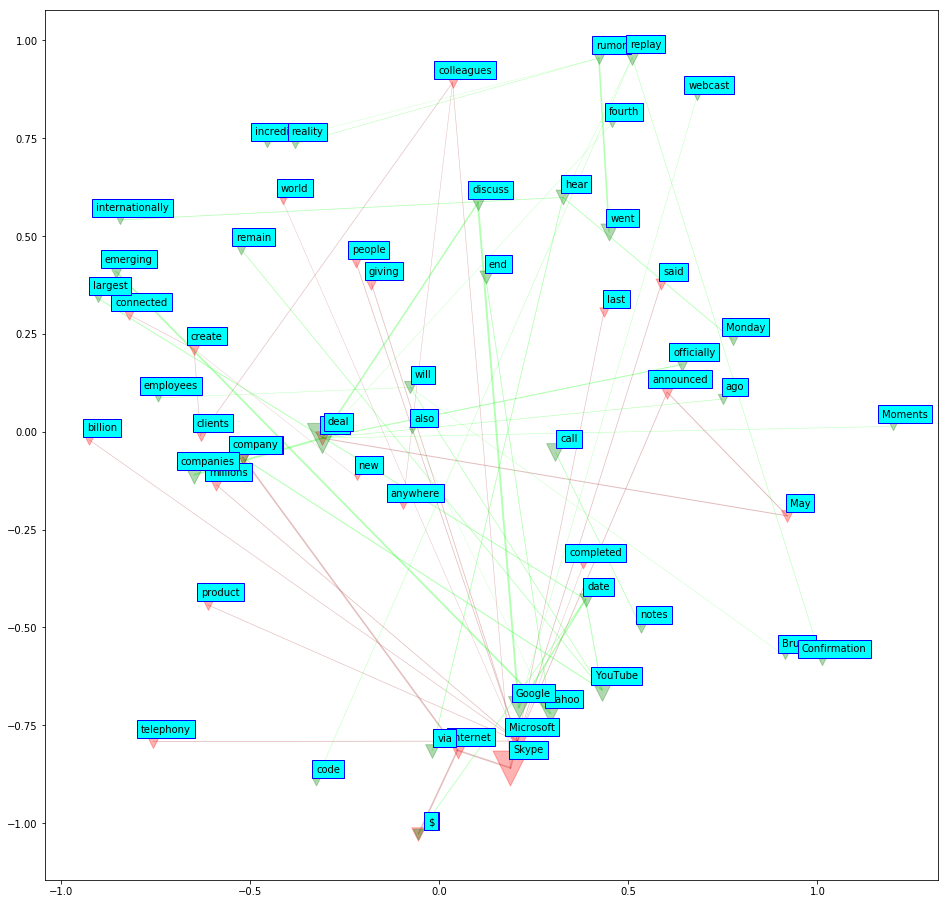

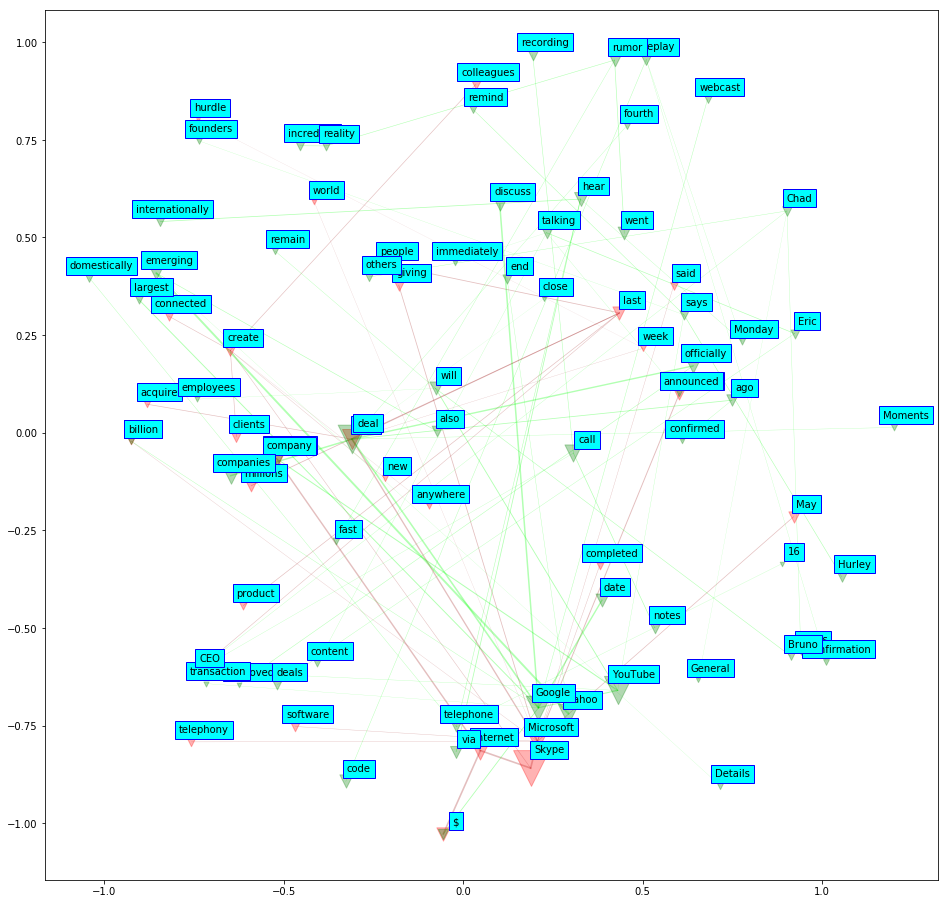

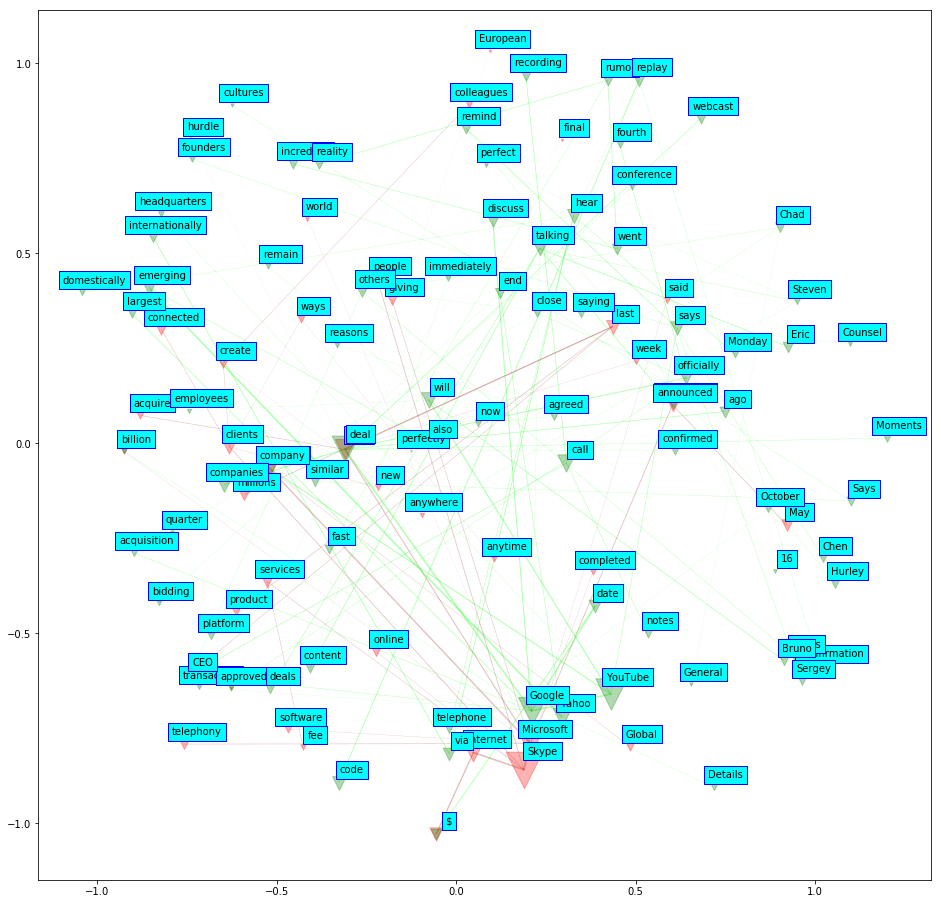

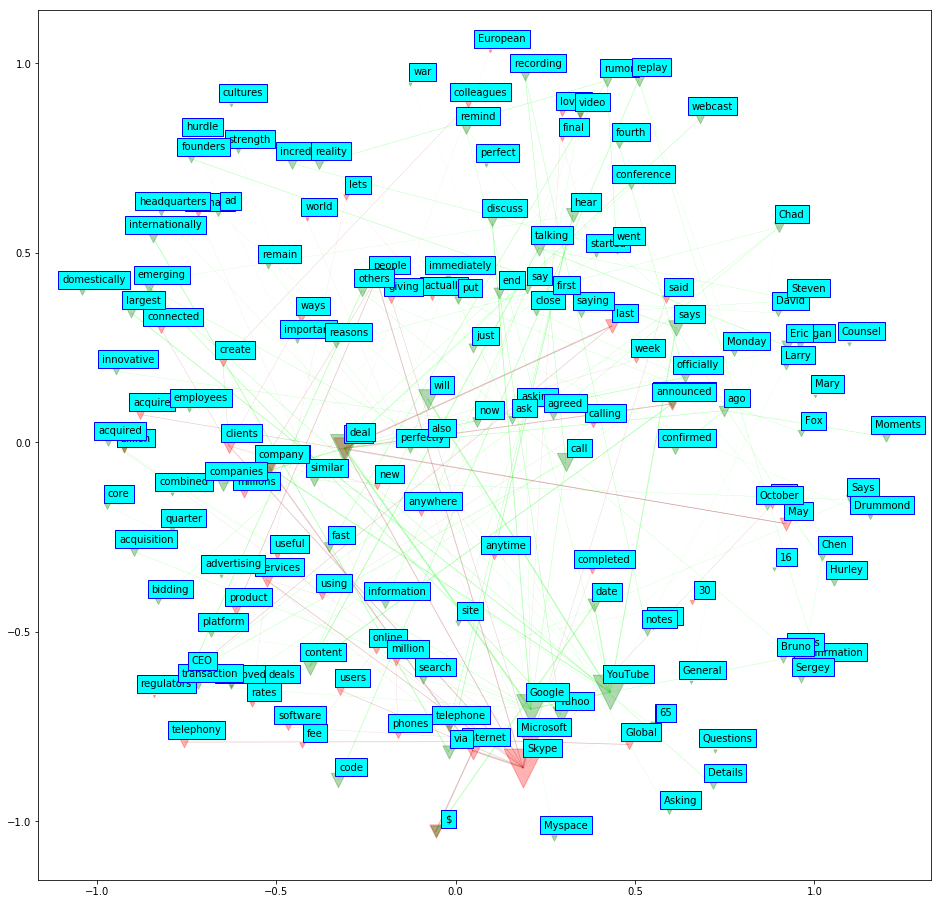

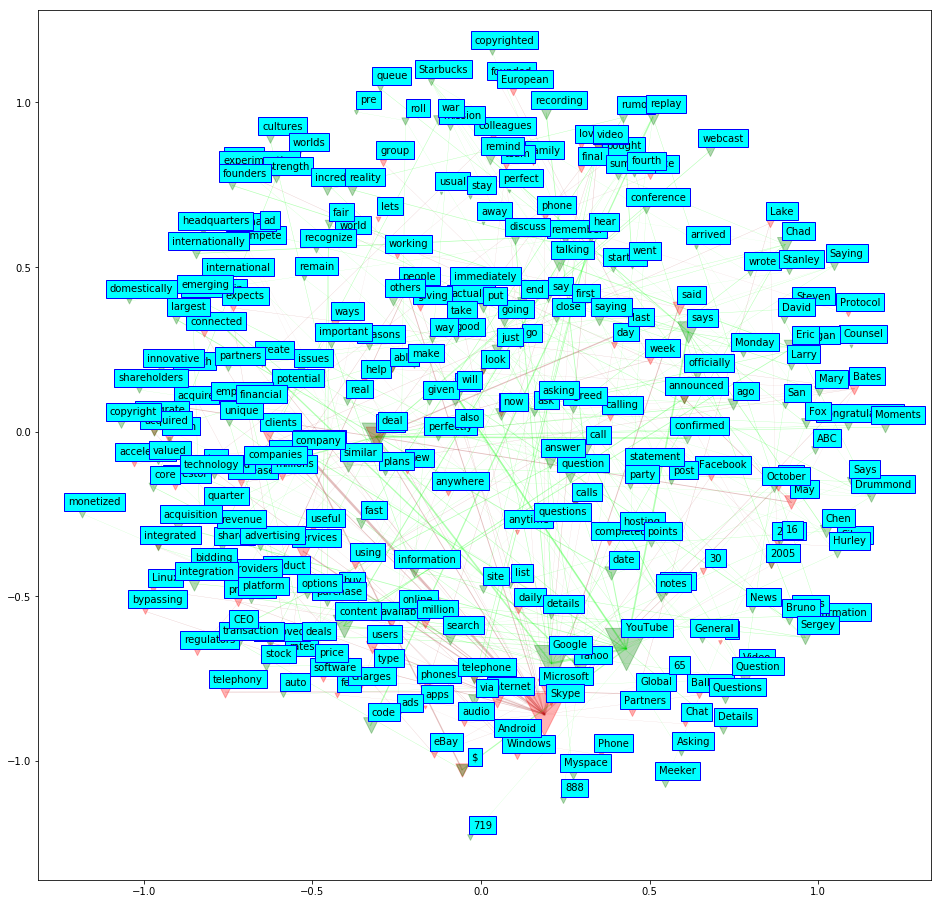

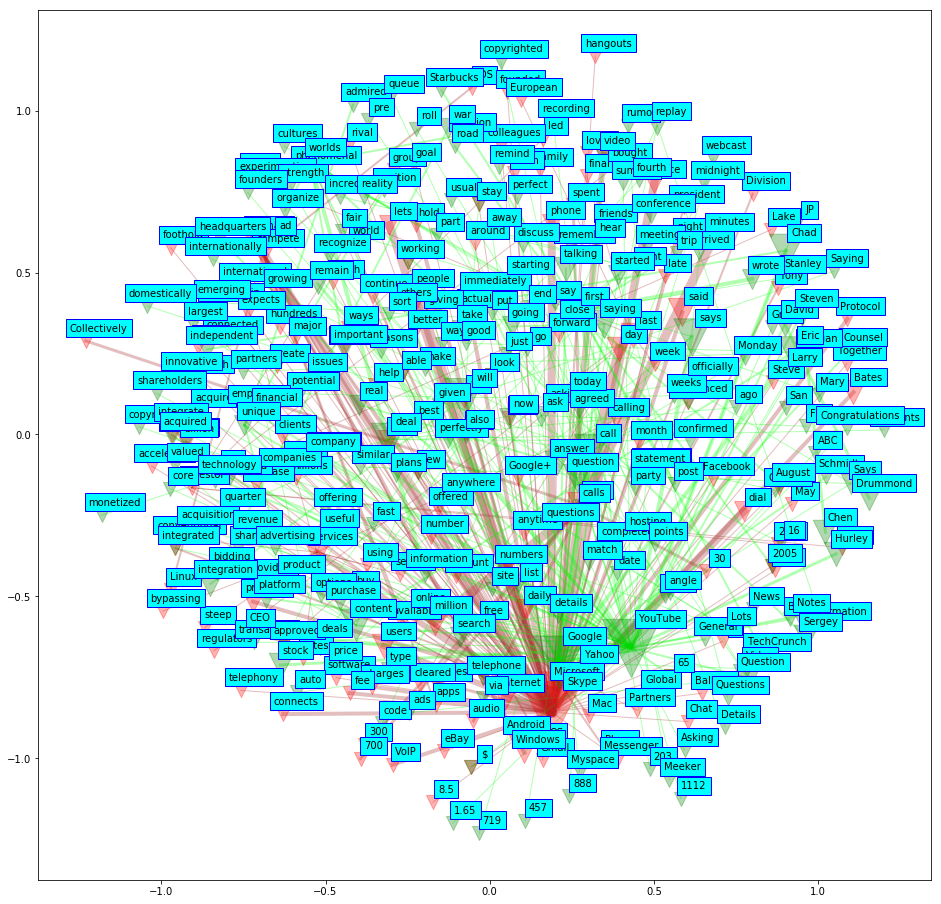

In [22]:

with open(args.stop_word_file) as f_in:
    stop_ind_set_doc = convert_stop_to_ind_lower(f_in, idx2word_freq)

word_norm_emb_doc_1, node_size_arr_doc_1, labels_doc_1, T_doc_1, document_list_1, word_norm_emb_arr_tensor_1, idx2word_freq_arr_1, idx_local_l2_idx_doc_arr_1 = doc_preprocessing(document_str_1, stop_ind_set_doc)
word_norm_emb_doc_2, node_size_arr_doc_2, labels_doc_2, T_doc_2, document_list_2, word_norm_emb_arr_tensor_2, idx2word_freq_arr_2, idx_local_l2_idx_doc_arr_2 = doc_preprocessing(document_str_2, stop_ind_set_doc)

doc_word_embs_low_1, doc_word_embs_low_2 = join_mds_emb(word_norm_emb_doc_1, word_norm_emb_doc_2, labels_doc_1, labels_doc_2, device)

node_c_1 = 'red'
edge_c_1 = 'brown'
node_c_2 = 'green'
edge_c_2 = 'lime'

compare_summarization(node_c_1, edge_c_1, doc_word_embs_low_1, node_size_arr_doc_1, labels_doc_1, T_doc_1, document_list_1, word_norm_emb_arr_tensor_1, idx2word_freq_arr_1, idx_local_l2_idx_doc_arr_1)
compare_summarization(node_c_2, edge_c_2, doc_word_embs_low_2, node_size_arr_doc_2, labels_doc_2, T_doc_2, document_list_2, word_norm_emb_arr_tensor_2, idx2word_freq_arr_2, idx_local_l2_idx_doc_arr_2)


    

161 unique words
Truncation rate:  0.0


/home/hschang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/hschang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Number of nodes:  87
Truncation rate:  0.0
Number of nodes:  41
Truncation rate:  0.0
Number of nodes:  28
Truncation rate:  0.0
Number of nodes:  24
Truncation rate:  0.0
Number of nodes:  24


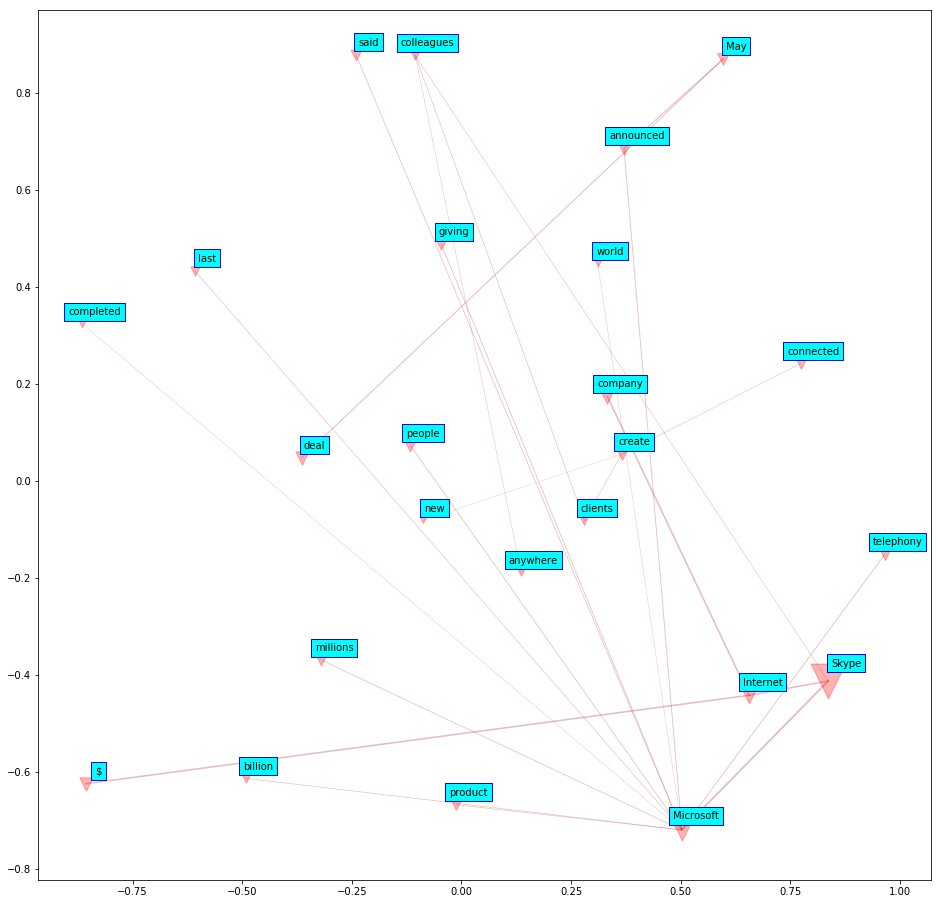

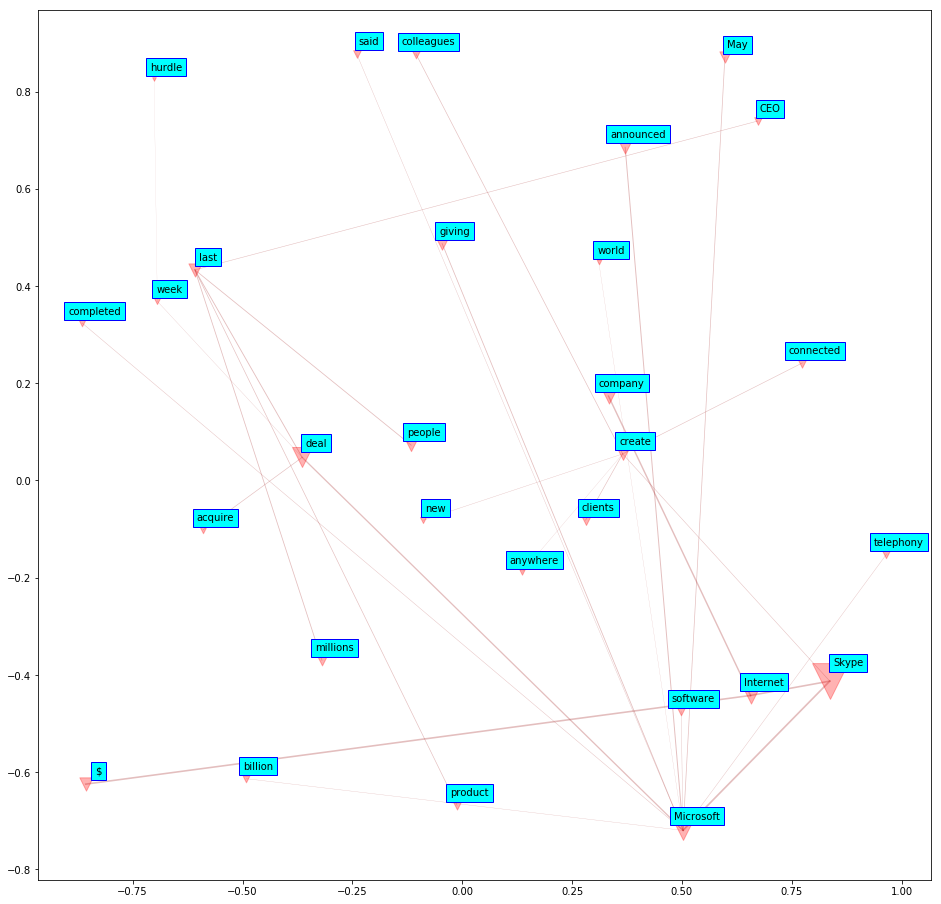

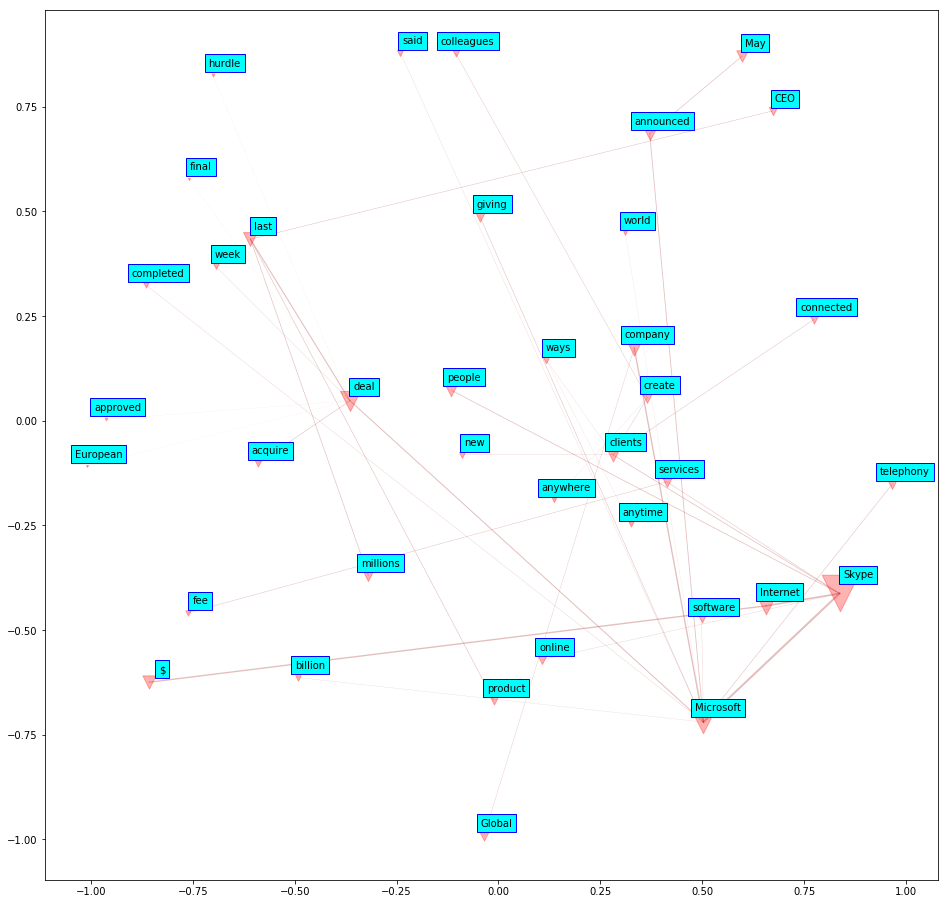

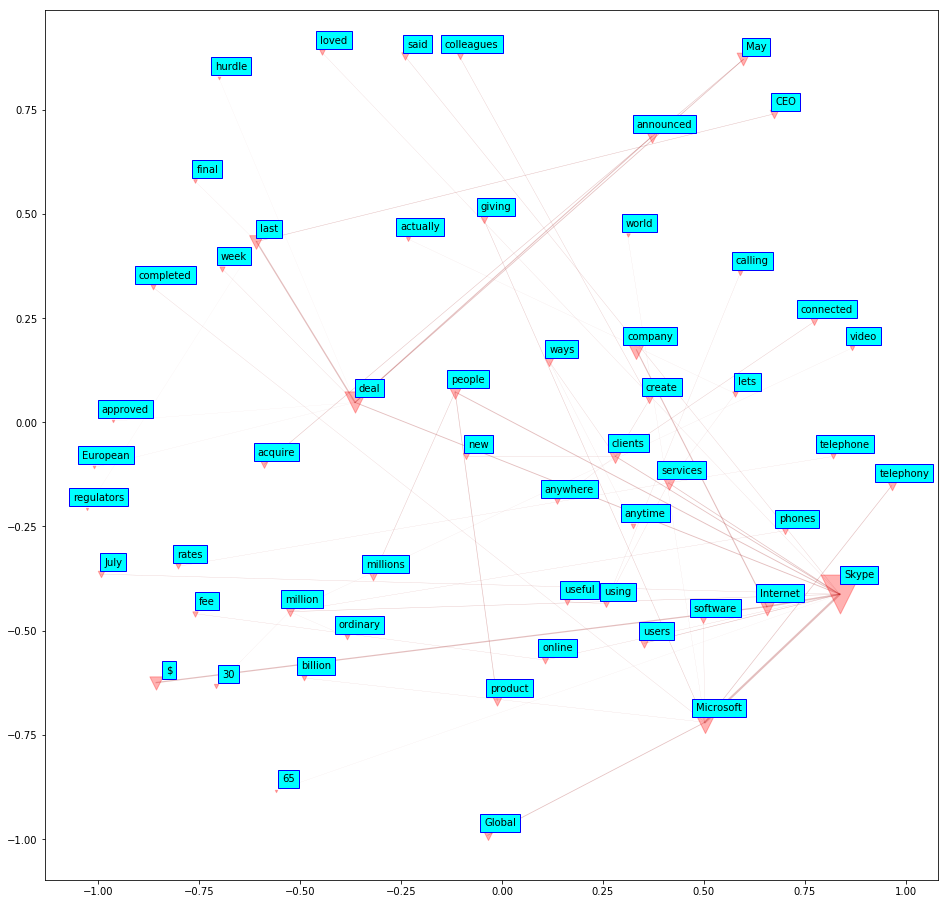

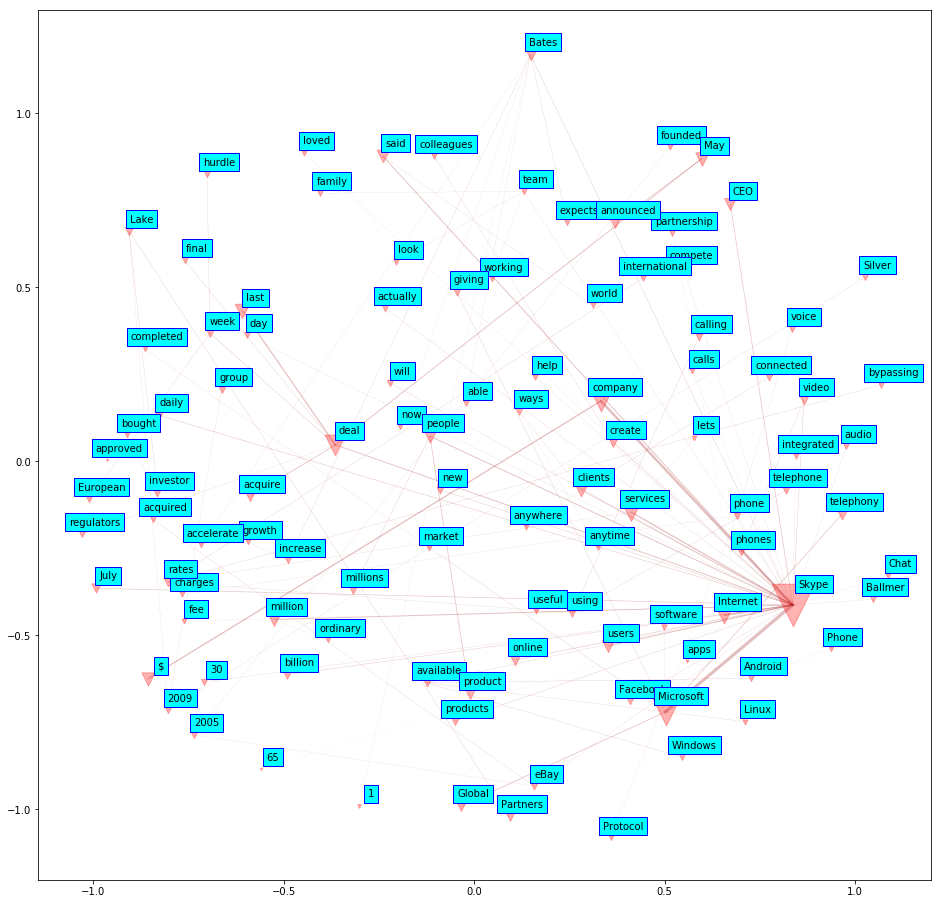

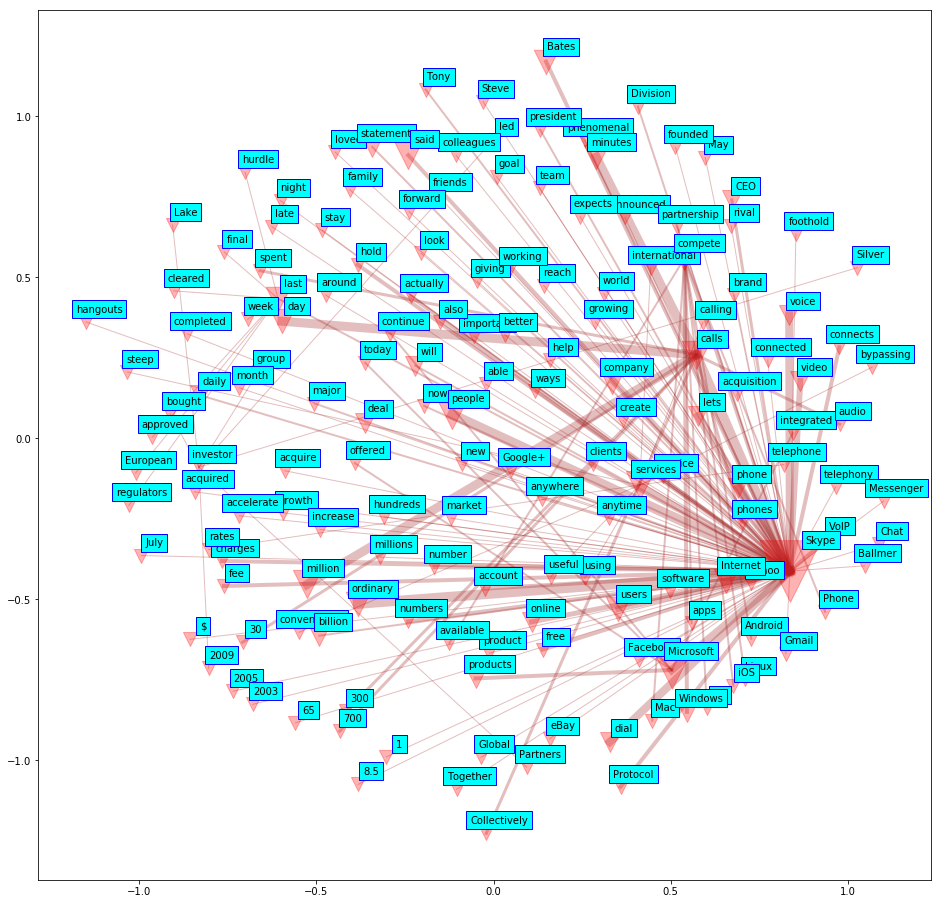

In [17]:
with open(args.stop_word_file) as f_in:
    stop_ind_set_doc = convert_stop_to_ind_lower(f_in, idx2word_freq)

word_norm_emb_doc_1, node_size_arr_doc_1, labels_doc_1, T_doc_1, document_list_1, word_norm_emb_arr_tensor_1, idx2word_freq_arr_1, idx_local_l2_idx_doc_arr_1 = doc_preprocessing(document_str_1, stop_ind_set_doc)

mds_model = MDS()
doc_word_embs_low_1 = mds_model.fit_transform(word_norm_emb_doc_1)

node_c_1 = 'red'
edge_c_1 = 'brown'
compare_summarization(node_c_1, edge_c_1, doc_word_embs_low_1, node_size_arr_doc_1, labels_doc_1, T_doc_1, document_list_1, word_norm_emb_arr_tensor_1, idx2word_freq_arr_1, idx_local_l2_idx_doc_arr_1)


In [18]:

# #num_sent_pred = 5
# #num_sent_pred = 3
# #num_sent_pred = 2
# #num_sent_pred = 1

# #print(document_str)
# document_word_idx, document_list, document_proc_list = spacy_parse(document_str, spacy_tokenizer, word_d2_idx_freq)
# #print(document_proc_list)
# #print(len(document_word_idx))
# #print(document_word_idx)
# #document_word_idx = convert_doc_to_idx(document_list, word_d2_idx)

# #word_norm_emb_doc = word_norm_emb
# #idx2word_freq_doc = idx2word_freq[0:5]
# with open(args.stop_word_file) as f_in:
#     stop_ind_set_doc = convert_stop_to_ind_lower(f_in, idx2word_freq)

# document_word_idx_flat = [w_idx for w_list in document_word_idx for w_idx in w_list if w_idx not in stop_ind_set_doc]
# document_word_idx_uniq = list(set(document_word_idx_flat))
# print(str(len(document_word_idx_uniq)) + ' unique words')

# #all_word_embs_low = dimension_reduction_model(document_word_idx_uniq, word_norm_emb)



# word_norm_emb_doc, idx2word_freq_doc = constraint_word_space(document_word_idx_uniq, word_norm_emb, idx2word_freq, device)

# w_idx_d2_local_idx = {}
# for i in range(len(document_word_idx_uniq)):
#     w_idx_d2_local_idx[document_word_idx_uniq[i]] = i

# word_norm_emb_arr_tensor, idx2word_freq_arr, idx_local_l2_idx_doc_arr = constraint_word_space_sent(document_word_idx, stop_ind_set_doc, word_norm_emb, idx2word_freq, w_idx_d2_local_idx, device)
    
# doc_word_embs_low = mds_model.fit_transform(word_norm_emb_doc)
# #document_word_idx_uniq = list(set([w_idx for w_list in document_word_idx for w_idx in w_list]))
# #print(str(len(document_word_idx_uniq)) + ' unique words')
# #print(max(document_word_idx_uniq))
# #print(word_norm_emb.size())
# #word_norm_emb_doc = word_norm_emb[torch.tensor(document_word_idx_uniq[:10],dtype=torch.long,device=device),:]
# #word_norm_emb_doc = word_norm_emb[torch.tensor([0,1,2,3,4],dtype=torch.long,device=device),:]
# #print(word_norm_emb_doc)
# #idx2word_freq_doc = [idx2word_freq[x] for x in document_word_idx_uniq]

# #print(len(document_list))
# #print(len([w for w_list in document_list for w in w_list]))
# #article, reaching_max_len_num = merge_sents(document_list, num_sent_pred, max_sent_len)
# #print(len(article), reaching_max_len_num)
# #print(len([w for w_list in article for w in w_list]))
# #print([len(w_list) for w_list in article])
# basis_pool = None
# top_k_pool = None
# del basis_pool, top_k_pool
# batch_size = args.batch_size
# batch_size = 10

# #document_list_flat =[w for w_list in document_list for w in w_list]
# #doc_counter = Counter(document_list_flat)
# node_size_arr_doc, labels_doc, T_doc = compute_word_graph(document_word_idx_uniq, document_word_idx_flat, w_idx_d2_local_idx, idx2word_freq_doc, stop_ind_set_doc)


# visualize_embs(doc_word_embs_low, node_size_arr_doc, labels_doc, T_doc)

# all_basis_embs_low_hier = []
# node_size_arr_hier = [] 
# i_nei_d2_link_arr_hier = []
# labels_hier = []

# #num_sent_pred_max = 3
# num_sent_pred_max = 5

# for num_sent_pred in range(1,num_sent_pred_max+1):
# #for num_sent_pred in range(1,2):
#     #basis_pool, top_k_pool = compute_bases(num_sent_pred, word_d2_idx_freq, document_list, parallel_encoder, parallel_decoder, word_norm_emb_doc, max_sent_len, batch_size , device)
#     basis_pool, top_k_pool, top_k_value_pool = compute_bases(num_sent_pred, word_d2_idx_freq, document_list, parallel_encoder, parallel_decoder, word_norm_emb_arr_tensor, max_sent_len, batch_size , device)
#     #document_word_idx
#     #convert to tensor
#     #print(all_basis_embs_low.shape)
#     #print(top_k_pool[0].size())
#     #print(basis_pool)
#     #all_basis_embs_low, center_embs_low, labels = compress_basis(basis_pool, top_k_pool, idx2word_freq_doc, stop_ind_set_doc)
#     all_basis_embs_low, node_size_arr, i_nei_d2_link_arr, labels, T = compress_basis(basis_pool, top_k_pool, top_k_value_pool, idx2word_freq_arr, idx_local_l2_idx_doc_arr, doc_word_embs_low)
#     #all_basis_embs_low, node_size_arr, i_nei_d2_link_arr, labels, T = compress_basis(basis_pool, top_k_pool, idx2word_freq_doc, doc_word_embs_low)
#     all_basis_embs_low_hier.append(all_basis_embs_low)
#     node_size_arr_hier.append(node_size_arr)
#     i_nei_d2_link_arr_hier.append(i_nei_d2_link_arr)
#     labels_hier.append(labels)
#     print("Number of nodes: ", len(node_size_arr))
#     #print(T)
#     #visualize_embs(center_embs_low, all_basis_embs_low, labels)


#     #visualize_embs(all_basis_embs_low, node_size_arr, i_nei_d2_link_arr, labels, T)
#     visualize_embs(all_basis_embs_low, node_size_arr, labels, T)

# for i_base in range(num_sent_pred_max-1,-1,-1):
#     all_basis_embs_low, node_size_arr, labels, T = merge_graph(all_basis_embs_low_hier[i_base:], node_size_arr_hier[i_base:], i_nei_d2_link_arr_hier[i_base:], labels_hier[i_base:])
#     visualize_embs(all_basis_embs_low, node_size_arr, labels, T)
    

In [19]:

# #num_sent_pred = 5
# #num_sent_pred = 3
# #num_sent_pred = 2
# #num_sent_pred = 1

# #print(document_str)
# document_word_idx, document_list, document_proc_list = spacy_parse(document_str, spacy_tokenizer, word_d2_idx_freq)
# #print(document_proc_list)
# #print(len(document_word_idx))
# #print(document_word_idx)
# #document_word_idx = convert_doc_to_idx(document_list, word_d2_idx)

# #word_norm_emb_doc = word_norm_emb
# #idx2word_freq_doc = idx2word_freq[0:5]
# with open(args.stop_word_file) as f_in:
#     stop_ind_set_doc = convert_stop_to_ind_lower(f_in, idx2word_freq)

# document_word_idx_flat = [w_idx for w_list in document_word_idx for w_idx in w_list if w_idx not in stop_ind_set_doc]
# document_word_idx_uniq = list(set(document_word_idx_flat))
# print(str(len(document_word_idx_uniq)) + ' unique words')

# #all_word_embs_low = dimension_reduction_model(document_word_idx_uniq, word_norm_emb)


# word_norm_emb_arr, idx2word_freq_arr = constraint_word_space_sent(document_word_idx, stop_ind_set_doc, word_norm_emb, idx2word_freq)
# word_norm_emb_doc, idx2word_freq_doc = constraint_word_space(document_word_idx_uniq, word_norm_emb, idx2word_freq, device)


# doc_word_embs_low = mds_model.fit_transform(word_norm_emb_doc)
# #document_word_idx_uniq = list(set([w_idx for w_list in document_word_idx for w_idx in w_list]))
# #print(str(len(document_word_idx_uniq)) + ' unique words')
# #print(max(document_word_idx_uniq))
# #print(word_norm_emb.size())
# #word_norm_emb_doc = word_norm_emb[torch.tensor(document_word_idx_uniq[:10],dtype=torch.long,device=device),:]
# #word_norm_emb_doc = word_norm_emb[torch.tensor([0,1,2,3,4],dtype=torch.long,device=device),:]
# #print(word_norm_emb_doc)
# #idx2word_freq_doc = [idx2word_freq[x] for x in document_word_idx_uniq]

# #print(len(document_list))
# #print(len([w for w_list in document_list for w in w_list]))
# #article, reaching_max_len_num = merge_sents(document_list, num_sent_pred, max_sent_len)
# #print(len(article), reaching_max_len_num)
# #print(len([w for w_list in article for w in w_list]))
# #print([len(w_list) for w_list in article])
# basis_pool = None
# top_k_pool = None
# del basis_pool, top_k_pool
# batch_size = args.batch_size
# batch_size = 10

# #document_list_flat =[w for w_list in document_list for w in w_list]
# #doc_counter = Counter(document_list_flat)
# node_size_arr_doc, labels_doc, T_doc = compute_word_graph(document_word_idx_uniq, document_word_idx_flat, idx2word_freq_doc, stop_ind_set_doc)


# visualize_embs(doc_word_embs_low, node_size_arr_doc, labels_doc, T_doc)

# for num_sent_pred in range(1,6):
# #for num_sent_pred in range(1,2):
#     #basis_pool, top_k_pool = compute_bases(num_sent_pred, word_d2_idx_freq, document_list, parallel_encoder, parallel_decoder, word_norm_emb_doc, max_sent_len, batch_size , device)
#     basis_pool, top_k_pool = compute_bases(num_sent_pred, word_d2_idx_freq, document_list, parallel_encoder, parallel_decoder, word_norm_emb_arr, max_sent_len, batch_size , device)
#     #document_word_idx
#     #convert to tensor
#     #print(all_basis_embs_low.shape)
#     #print(top_k_pool[0].size())
#     #print(basis_pool)
#     #all_basis_embs_low, center_embs_low, labels = compress_basis(basis_pool, top_k_pool, idx2word_freq_doc, stop_ind_set_doc)
#     all_basis_embs_low, node_size_arr, i_nei_d2_link_arr, labels, T = compress_basis(basis_pool, top_k_pool, idx2word_freq_arr, doc_word_embs_low)
#     #all_basis_embs_low, node_size_arr, i_nei_d2_link_arr, labels, T = compress_basis(basis_pool, top_k_pool, idx2word_freq_doc, doc_word_embs_low)
#     print("Number of nodes: ", len(node_size_arr))
#     #print(T)
#     #visualize_embs(center_embs_low, all_basis_embs_low, labels)


#     #visualize_embs(all_basis_embs_low, node_size_arr, i_nei_d2_link_arr, labels, T)
#     visualize_embs(all_basis_embs_low, node_size_arr, labels, T)


In [20]:
# #print(basis_pool)

# #print(T.edges(data=True))
# document_word_idx_flat = [w_idx for w_list in document_word_idx for w_idx in w_list if w_idx not in stop_ind_set_doc]
# document_word_idx_uniq = list(set(document_word_idx_flat))
# print(str(len(document_word_idx_uniq)) + ' unique words')

# document_word_idx_flat = [w_idx for w_list in document_word_idx for w_idx in w_list]
# document_word_idx_uniq = list(set(document_word_idx_flat))
# print(str(len(document_word_idx_uniq)) + ' unique words')

# print(len(stop_ind_set_doc))